In [153]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%reload_ext lab_black
%config InlineBackend.figure_format = 'retina'

In [175]:
import numpy as np
import matplotlib.pyplot as plt

import logging

logging.basicConfig(level=logging.INFO)

In [176]:
epoch_key = ("jaq", 1, 2)  # animal, day, epoch

In [174]:
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()

In [173]:
place_bin_size = 2.5
edge_order = [6, 5, 3, 8, 7, 4, 2, 0, 1]
edge_spacing = 15

In [172]:
from src.load_data import convert_linear_distance_to_linear_position
from scipy.interpolate import interp1d
import networkx as nx

track_graph1 = track_graph.copy()
n_nodes = len(track_graph.nodes)

for edge_ind, (node1, node2) in enumerate(track_graph.edges):
    node1_x_pos, node1_y_pos = track_graph.nodes[node1]["pos"]
    node2_x_pos, node2_y_pos = track_graph.nodes[node2]["pos"]

    edge_size = np.linalg.norm(
        [(node2_x_pos - node1_x_pos), (node2_y_pos - node1_y_pos)]
    )
    n_bins = 2 * np.ceil(edge_size / place_bin_size).astype(np.int) + 1

    f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))

    xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)
    xy = np.stack((xnew, f(xnew)), axis=1)
    dist_between_nodes = np.linalg.norm(np.diff(xy, axis=0), axis=1)

    new_node_ids = n_nodes + np.arange(len(dist_between_nodes) + 1)
    nx.add_path(track_graph1, [*new_node_ids], distance=dist_between_nodes[0])
    nx.add_path(track_graph1, [node1, new_node_ids[0]], distance=0)
    nx.add_path(track_graph1, [node2, new_node_ids[-1]], distance=0)
    track_graph1.remove_edge(node1, node2)
    for ind, (node_id, pos) in enumerate(zip(new_node_ids, xy)):
        track_graph1.nodes[node_id]["pos"] = pos
        track_graph1.nodes[node_id]["track_segment_id"] = edge_ind
        track_graph1.nodes[node_id]["is_bin_edge"] = False if ind % 2 else True
    track_graph1.nodes[node1]["track_segment_id"] = edge_ind
    track_graph1.nodes[node2]["track_segment_id"] = edge_ind
    track_graph1.nodes[node1]["is_bin_edge"] = True
    track_graph1.nodes[node2]["is_bin_edge"] = True
    n_nodes = len(track_graph1.nodes)

In [171]:
new_node_ids

array([132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146])

In [170]:
new_node_ids[1::2]

array([133, 135, 137, 139, 141, 143, 145])

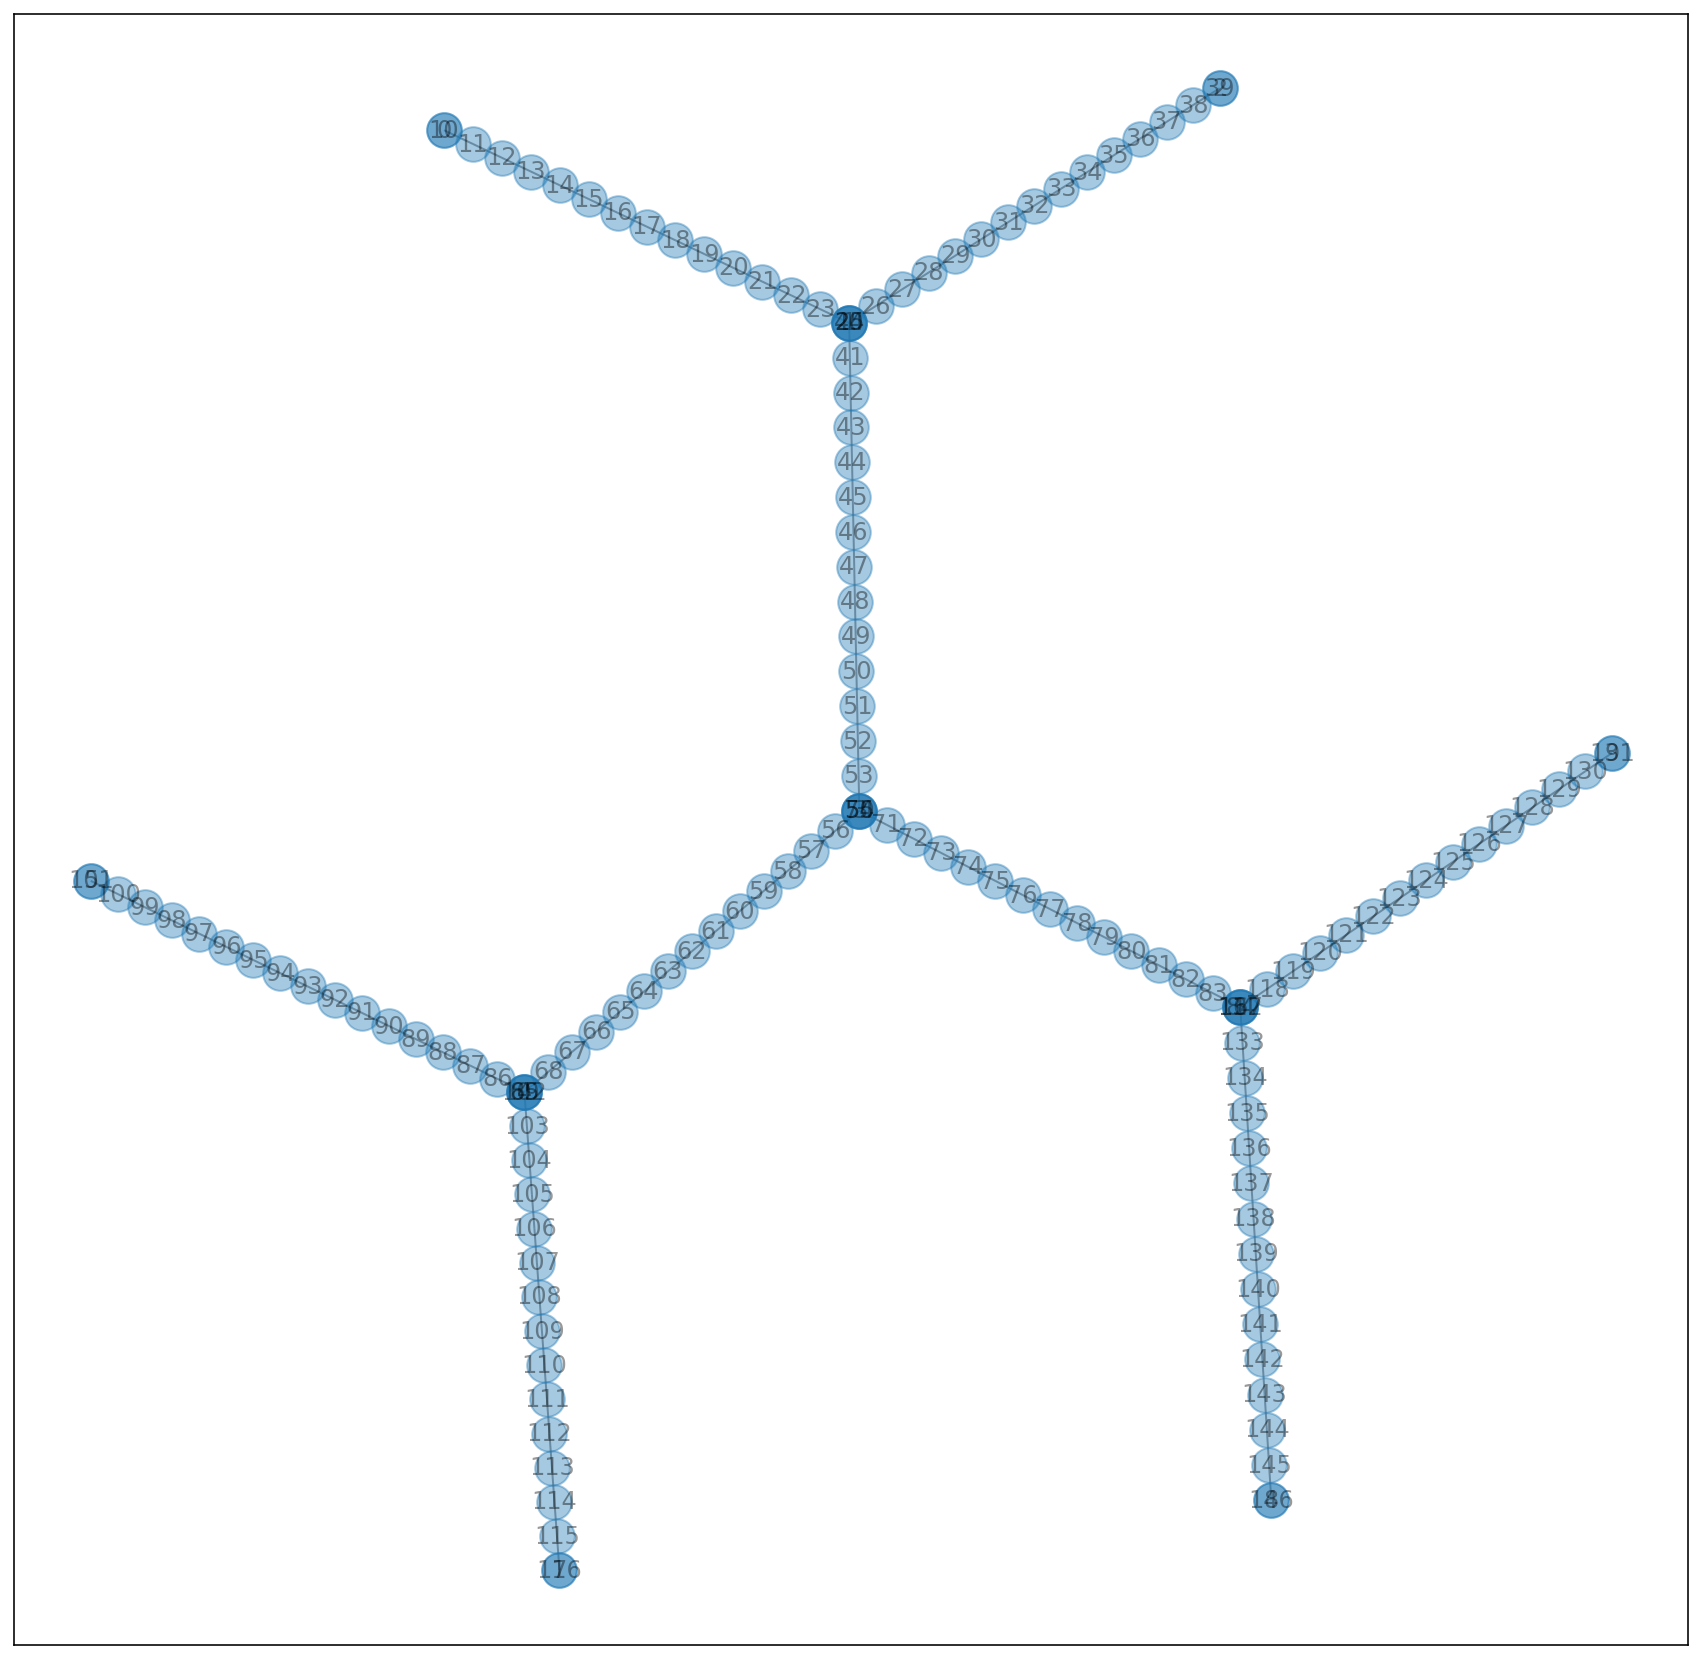

In [169]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

node_position = nx.get_node_attributes(track_graph1, "pos")
nx.draw_networkx(track_graph1, node_position, ax=ax, alpha=0.4)

In [168]:
distance = dict(nx.all_pairs_dijkstra_path_length(track_graph1, weight="distance"))

node_ids, linear_distance = list(zip(*distance[center_well_id].items()))
ids = nx.get_node_attributes(track_graph1, "track_segment_id")
track_segment_id = np.array([ids[node_id] for node_id in node_ids])
ids = nx.get_node_attributes(track_graph1, "is_bin_edge")
is_bin_edge = np.array([ids[node_id] for node_id in node_ids])
linear_distance = np.array(linear_distance)

linear_position = convert_linear_distance_to_linear_position(
    linear_distance, track_segment_id, edge_order, spacing=edge_spacing
)

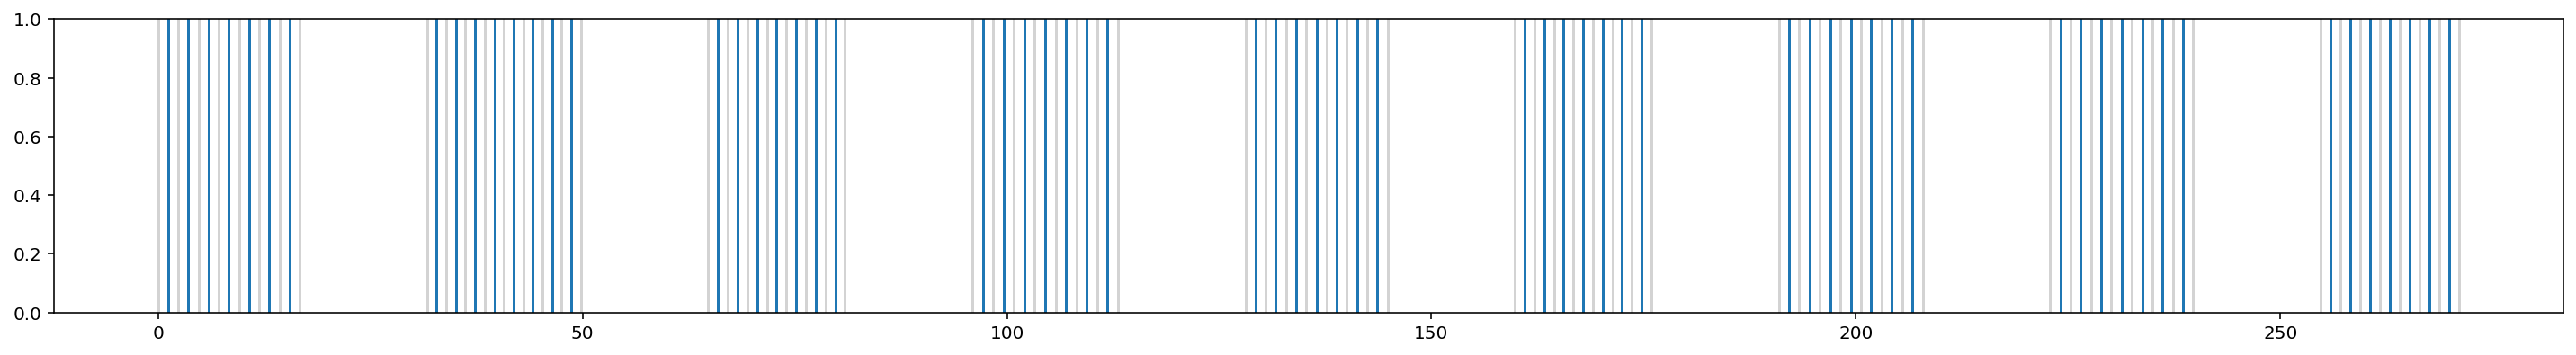

In [167]:
plt.figure(figsize=(25, 3))

for pos in linear_position[~is_bin_edge]:
    plt.axvline(pos)

for pos in linear_position[is_bin_edge]:
    plt.axvline(pos, color="lightgrey")

In [166]:
np.diff(np.unique(linear_position[is_bin_edge]))

array([ 2.38185934,  2.38185934,  2.38185934,  2.38185934,  2.38185934,
        2.38185934,  2.38185934, 15.        ,  2.26637026,  2.26637026,
        2.26637026,  2.26637026,  2.26637026,  2.26637026,  2.26637026,
        2.26637026, 15.        ,  2.30159605,  2.30159605,  2.30159605,
        2.30159605,  2.30159605,  2.30159605,  2.30159605, 15.        ,
        2.45343848,  2.45343848,  2.45343848,  2.45343848,  2.45343848,
        2.45343848,  2.45343848, 15.        ,  2.39133171,  2.39133171,
        2.39133171,  2.39133171,  2.39133171,  2.39133171,  2.39133171,
       15.        ,  2.29849956,  2.29849956,  2.29849956,  2.29849956,
        2.29849956,  2.29849956,  2.29849956, 15.        ,  2.42221227,
        2.42221227,  2.42221227,  2.42221227,  2.42221227,  2.42221227,
        2.42221227, 15.        ,  2.41102265,  2.41102265,  2.41102265,
        2.41102265,  2.41102265,  2.41102265,  2.41102265, 15.        ,
        2.33558508,  2.33558508,  2.33558508,  2.33558508,  2.33

In [165]:
np.diff(np.unique(linear_position[~is_bin_edge]))

array([ 2.38185934,  2.38185934,  2.38185934,  2.38185934,  2.38185934,
        2.38185934, 17.3241148 ,  2.26637026,  2.26637026,  2.26637026,
        2.26637026,  2.26637026,  2.26637026,  2.26637026, 17.28398315,
        2.30159605,  2.30159605,  2.30159605,  2.30159605,  2.30159605,
        2.30159605, 17.37751726,  2.45343848,  2.45343848,  2.45343848,
        2.45343848,  2.45343848,  2.45343848, 17.42238509,  2.39133171,
        2.39133171,  2.39133171,  2.39133171,  2.39133171,  2.39133171,
       17.34491564,  2.29849956,  2.29849956,  2.29849956,  2.29849956,
        2.29849956,  2.29849956, 17.36035592,  2.42221227,  2.42221227,
        2.42221227,  2.42221227,  2.42221227,  2.42221227, 17.41661746,
        2.41102265,  2.41102265,  2.41102265,  2.41102265,  2.41102265,
        2.41102265, 17.37330386,  2.33558508,  2.33558508,  2.33558508,
        2.33558508,  2.33558508,  2.33558508])

In [164]:
from replay_trajectory_classification.core import get_centers

place_bin_edges = np.unique(linear_position[is_bin_edge])
place_bin_centers = get_centers(place_bin_edges)
interior_bin_centers = linear_position[~is_bin_edge]
interior_bin_centers = interior_bin_centers[np.argsort(interior_bin_centers)]

is_track_interior = np.array(
    [
        np.any(np.isclose(interior_bin_centers, bin_center))
        for bin_center in place_bin_centers
    ]
)
is_track_interior

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True])

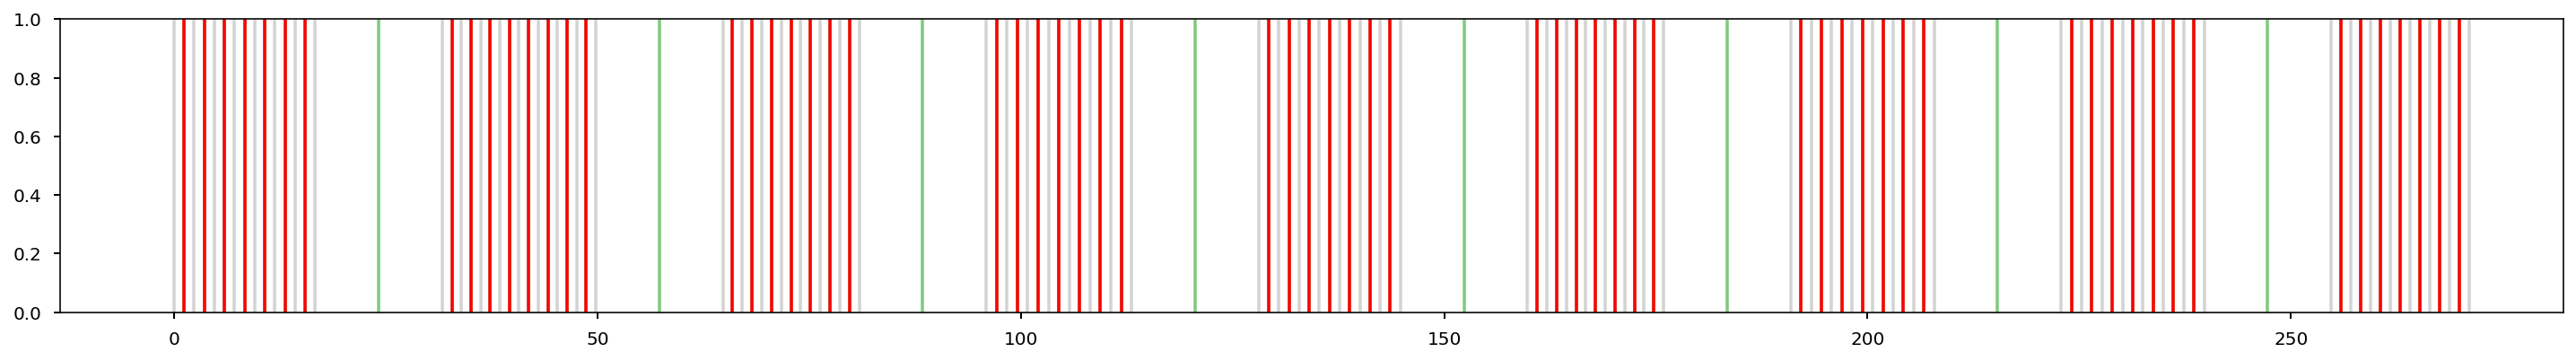

In [317]:
plt.figure(figsize=(25, 3))

for center in place_bin_edges:
    plt.axvline(center, color="lightgrey")

for center in place_bin_centers:
    plt.axvline(center)

for center in interior_bin_centers:
    plt.axvline(center, color="red")

for center in place_bin_centers[is_track_interior]:
    plt.axvline(center, color="green", linestyle="--")

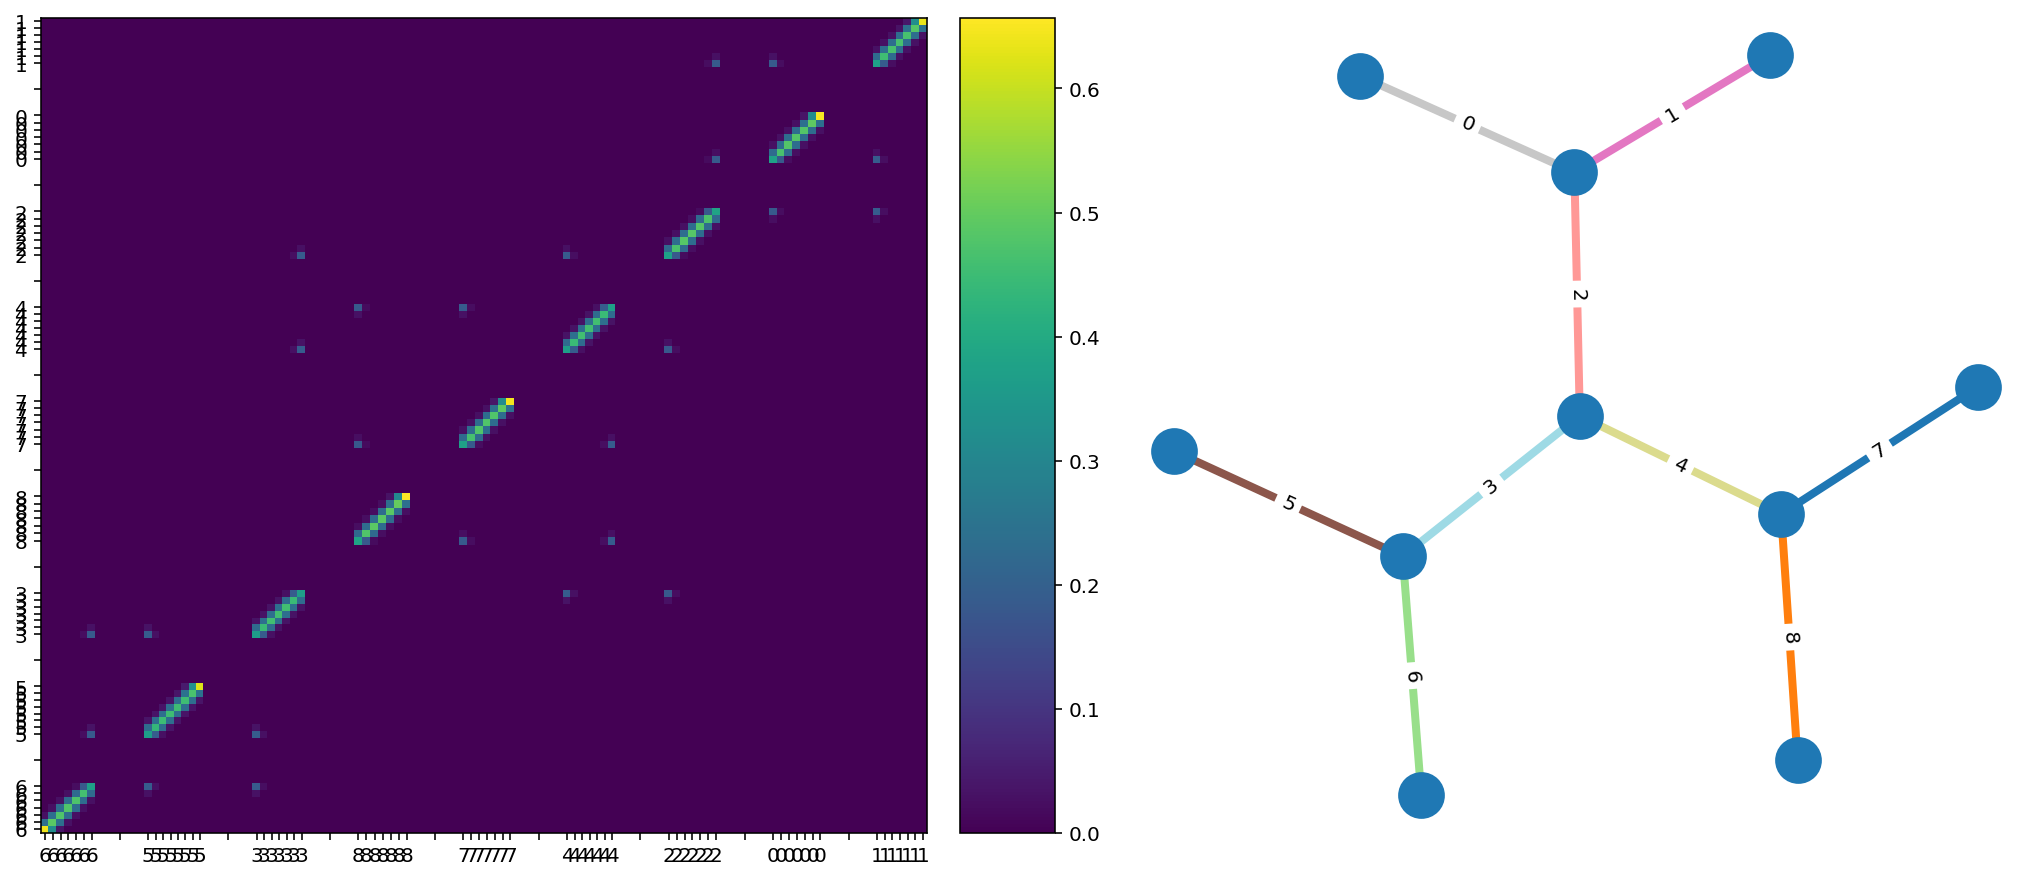

In [162]:
from scipy.ndimage import label

replay_speed = 1
movement_var = 4

close_ind = np.argmin(
    np.abs(linear_position - place_bin_centers[:, np.newaxis]), axis=1
)

state_transition = np.zeros((place_bin_centers.size, place_bin_centers.size))
gaussian = multivariate_normal(mean=0, cov=movement_var * replay_speed)

for bin_ind1, node_ind1 in enumerate(close_ind):
    for bin_ind2, node_ind2 in enumerate(close_ind):
        state_transition[bin_ind1, bin_ind2] = gaussian.pdf(
            distance[node_ids[node_ind1]][node_ids[node_ind2]]
        )

state_transition[~is_track_interior] = 0
state_transition[:, ~is_track_interior] = 0

state_transition = _normalize_row_probability(state_transition)

labels, _ = label(is_track_interior)
bin_edge = []
for label in labels:
    if label != 0:
        bin_edge.append(f"{edge_order[label-1]}")
    else:
        bin_edge.append("")


fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(place_bin_edges, place_bin_edges, state_transition)
axes[0].set_xticks(place_bin_centers)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(place_bin_centers)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0])

node_position = nx.get_node_attributes(track_graph, "pos")
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(
    track_graph,
    node_position,
    ax=axes[1],
    edge_color=edge_order,
    width=4,
    alpha=1,
    edge_cmap=plt.get_cmap("tab20"),
    with_labels=False,
    node_size=500,
)
nx.draw_networkx_edge_labels(
    track_graph, node_position, ax=axes[1], edge_labels=edge_labels
)
plt.axis("off")

In [161]:
# from scipy.stats import multivariate_normal
# from replay_trajectory_classification.state_transition import _normalize_row_probability
# from scipy.ndimage import label

# replay_speed=1
# movement_var=16
# is_track_interior = np.ones_like(place_bin_centers, dtype=np.bool)

# state_transition = np.zeros((place_bin_centers.size, place_bin_centers.size))
# gaussian = multivariate_normal(
#         mean=0, cov=movement_var * replay_speed)

# for bin_ind1, node_id1 in enumerate(blah[:, 0]):
#     for bin_ind2, node_id2 in enumerate(blah[:, 0]):
#         state_transition[bin_ind1, bin_ind2] = gaussian.pdf(
#                 distance[node_id1][node_id2])

# state_transition[~is_track_interior] = 0
# state_transition[:, ~is_track_interior] = 0

# state_transition = _normalize_row_probability(state_transition)

# # Plot
# bin_edge = blah[:, -1].astype(int)

# fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
# m = axes[0].pcolormesh(place_bin_edges, place_bin_edges, state_transition)
# axes[0].set_xticks(place_bin_centers)
# axes[0].set_xticklabels(bin_edge)
# axes[0].set_yticks(place_bin_centers)
# axes[0].set_yticklabels(bin_edge)
# plt.colorbar(m, ax=axes[0]);

# node_position = nx.get_node_attributes(track_graph, 'pos')
# edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
# nx.draw_networkx(track_graph, node_position, ax=axes[1],
#                  edge_color=edge_order, width=4, alpha=1,
#                  edge_cmap=plt.get_cmap('tab20'), with_labels=False,
#                  node_size=500)
# nx.draw_networkx_edge_labels(track_graph, node_position, ax=axes[1], edge_labels=edge_labels);
# plt.axis('off');

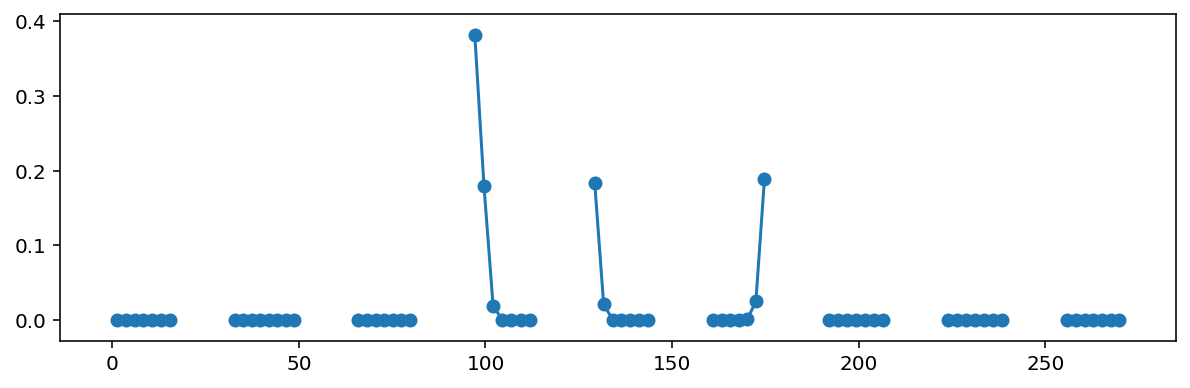

In [160]:
bin_ind = 25
mask = np.ones_like(place_bin_centers)
mask[~is_track_interior] = np.nan
plt.figure(figsize=(10, 3))
plt.plot(place_bin_centers, state_transition[bin_ind] * mask)
plt.scatter(place_bin_centers, state_transition[bin_ind] * mask)

In [257]:
def get_grid(track_graph, center_well_id, edge_order, edge_spacing):
    track_graph1 = track_graph.copy()
    n_nodes = len(track_graph.nodes)

    for edge_ind, (node1, node2) in enumerate(track_graph.edges):
        node1_x_pos, node1_y_pos = track_graph.nodes[node1]["pos"]
        node2_x_pos, node2_y_pos = track_graph.nodes[node2]["pos"]

        edge_size = np.linalg.norm(
            [(node2_x_pos - node1_x_pos), (node2_y_pos - node1_y_pos)]
        )
        n_bins = 2 * np.ceil(edge_size / place_bin_size).astype(np.int) + 1

        f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))

        xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)
        xy = np.stack((xnew, f(xnew)), axis=1)
        dist_between_nodes = np.linalg.norm(np.diff(xy, axis=0), axis=1)

        new_node_ids = n_nodes + np.arange(len(dist_between_nodes) + 1)
        nx.add_path(track_graph1, [*new_node_ids], distance=dist_between_nodes[0])
        nx.add_path(track_graph1, [node1, new_node_ids[0]], distance=0)
        nx.add_path(track_graph1, [node2, new_node_ids[-1]], distance=0)
        track_graph1.remove_edge(node1, node2)
        for ind, (node_id, pos) in enumerate(zip(new_node_ids, xy)):
            track_graph1.nodes[node_id]["pos"] = pos
            track_graph1.nodes[node_id]["track_segment_id"] = edge_ind
            track_graph1.nodes[node_id]["is_bin_edge"] = False if ind % 2 else True
        track_graph1.nodes[node1]["track_segment_id"] = edge_ind
        track_graph1.nodes[node2]["track_segment_id"] = edge_ind
        track_graph1.nodes[node1]["is_bin_edge"] = True
        track_graph1.nodes[node2]["is_bin_edge"] = True
        n_nodes = len(track_graph1.nodes)

    distance_between_nodes = dict(
        nx.all_pairs_dijkstra_path_length(track_graph1, weight="distance")
    )

    node_ids, linear_distance = list(
        zip(*distance_between_nodes[center_well_id].items())
    )
    linear_distance = np.array(linear_distance)

    ids = nx.get_node_attributes(track_graph1, "track_segment_id")
    track_segment_id = np.array([ids[node_id] for node_id in node_ids])

    ids = nx.get_node_attributes(track_graph1, "is_bin_edge")
    is_bin_edge = np.array([ids[node_id] for node_id in node_ids])

    node_linear_position = convert_linear_distance_to_linear_position(
        linear_distance, track_segment_id, edge_order, spacing=edge_spacing
    )

    place_bin_edges = np.unique(node_linear_position[is_bin_edge])
    place_bin_centers = get_centers(place_bin_edges)
    interior_bin_centers = node_linear_position[~is_bin_edge]
    interior_bin_centers = interior_bin_centers[np.argsort(interior_bin_centers)]

    is_track_interior = np.array(
        [
            np.any(np.isclose(interior_bin_centers, bin_center))
            for bin_center in place_bin_centers
        ]
    )

    closest_node_ind = np.argmin(
        np.abs(node_linear_position - place_bin_centers[:, np.newaxis]), axis=1
    )
    place_bin_center_ind_to_node = np.array([node_ids[ind] for ind in closest_node_ind])

    ids = nx.get_node_attributes(track_graph1, "pos")
    place_bin_center_2D_position = np.array(
        [ids[node_id] for node_id in place_bin_center_ind_to_node]
    )

    closest_node_ind = np.argmin(
        np.abs(node_linear_position - place_bin_edges[:, np.newaxis]), axis=1
    )
    place_bin_edge_ind_to_node = np.array([node_ids[ind] for ind in closest_node_ind])
    place_bin_edges_2D_position = np.array(
        [ids[node_id] for node_id in place_bin_edge_ind_to_node]
    )
    place_bin_edges_2D_position = np.stack(
        (place_bin_edges_2D_position[:-1], place_bin_edges_2D_position[1:]), axis=1
    )

    return (
        place_bin_centers,
        place_bin_edges,
        is_track_interior,
        distance_between_nodes,
        place_bin_center_ind_to_node,
        place_bin_center_2D_position,
        place_bin_edges_2D_position,
    )


def random_walk_on_track_graph(
    place_bin_centers,
    place_bin_edges,
    is_track_interior,
    distance_between_nodes,
    bin_to_node,
    movement_var=1,
    replay_speed=6,
):
    """
    
    Parameters
    ----------
    node_linear_position : np.ndarray, shape (n_nodes,)
    place_bin_centers : np.ndarray, shape (n_bins)
    is_track_interior : np.ndarray, shape (n_bins)
    distance_between_nodes : dict of dicts, shape (n_nodes, n_nodes)
    node_ids : tuple, shape (n_nodes,)
    movement_var : float, optional
    replay_speed : float, optional
    
    Returns
    -------
    state_transition : np.ndarray, shape (n_bins, n_bins)
    bin_to_node : np.array, shape (n_bins)
    
    """
    state_transition = np.zeros((place_bin_centers.size, place_bin_centers.size))
    gaussian = multivariate_normal(mean=0, cov=movement_var * replay_speed)

    for bin_ind1, node1 in enumerate(bin_to_node):
        for bin_ind2, node2 in enumerate(bin_to_node):
            state_transition[bin_ind1, bin_ind2] = gaussian.pdf(
                distance_between_nodes[node1][node2]
            )

    state_transition[~is_track_interior] = 0
    state_transition[:, ~is_track_interior] = 0

    state_transition = _normalize_row_probability(state_transition)

    return state_transition

In [258]:
(
    place_bin_centers,
    place_bin_edges,
    is_track_interior,
    distance_between_nodes,
    place_bin_center_ind_to_node,
    place_bin_center_2D_position,
    place_bin_edges_2D_position,
) = get_grid(track_graph, center_well_id, edge_order, edge_spacing)

state_transition = random_walk_on_track_graph(
    place_bin_centers,
    place_bin_edges,
    is_track_interior,
    distance_between_nodes,
    place_bin_center_ind_to_node,
    replay_speed=10,
)

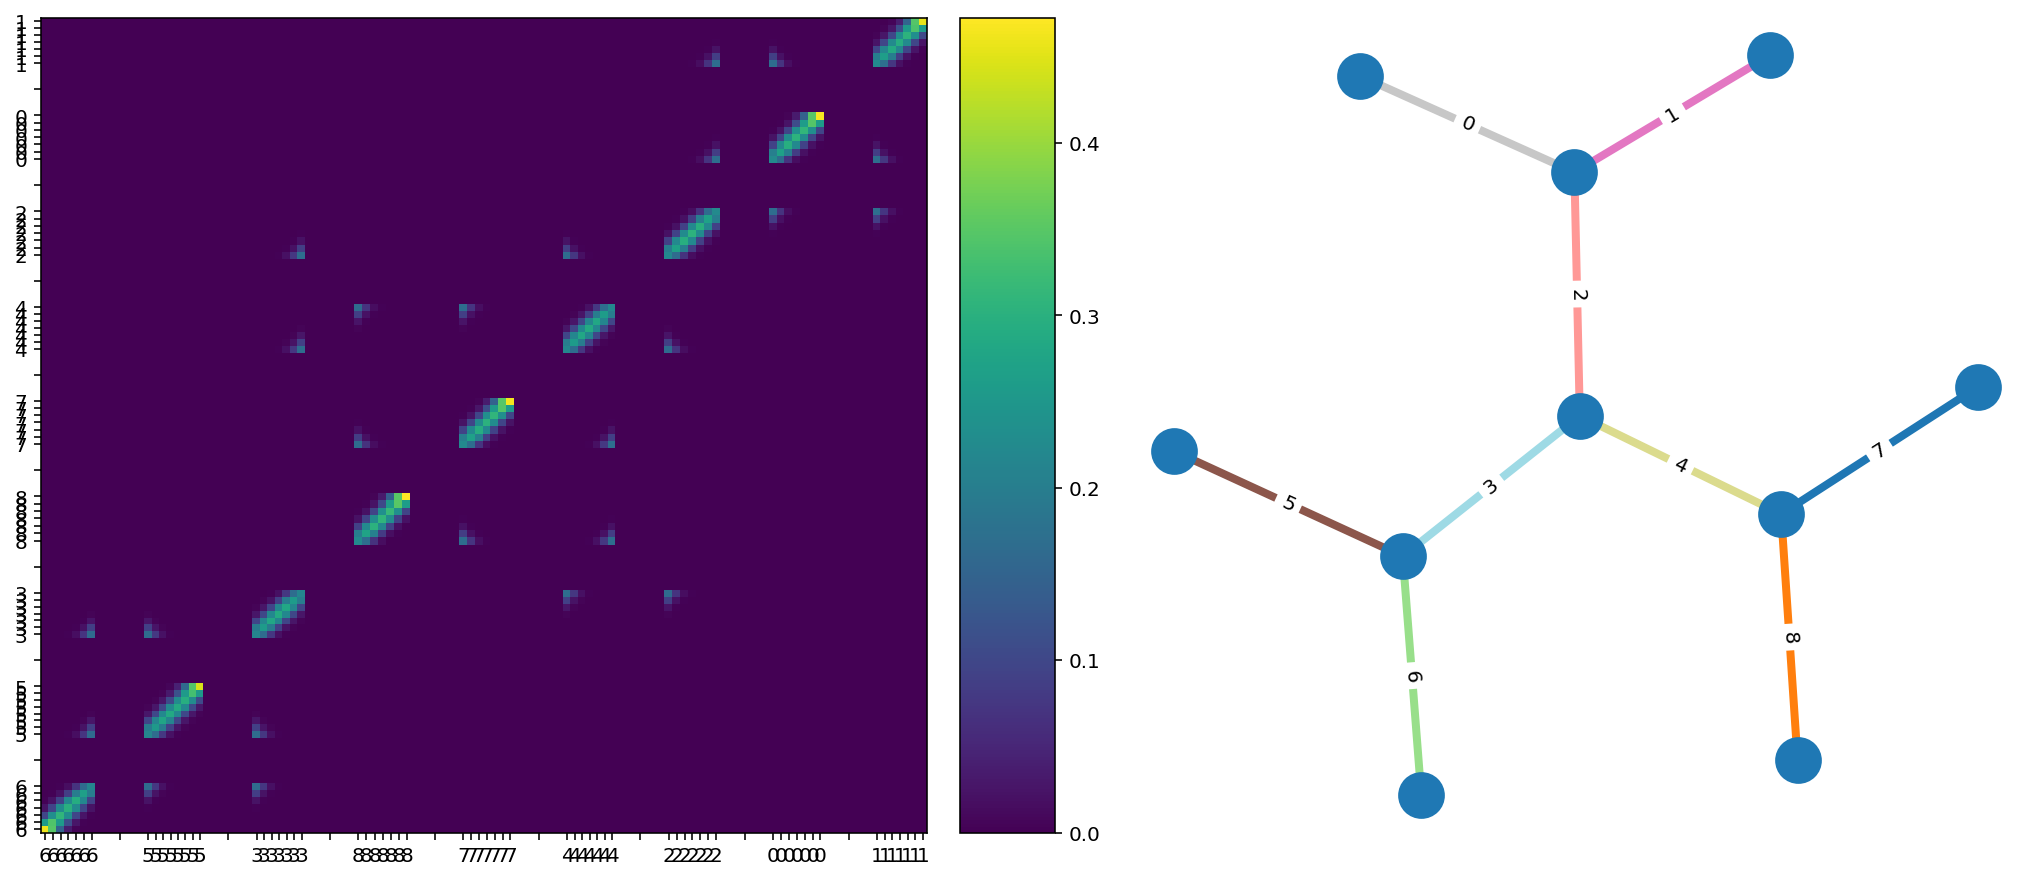

In [260]:
from scipy.ndimage import label

labels, _ = label(is_track_interior)
bin_edge = []
for label in labels:
    if label != 0:
        bin_edge.append(f"{edge_order[label-1]}")
    else:
        bin_edge.append("")


fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
m = axes[0].pcolormesh(place_bin_edges, place_bin_edges, state_transition)
axes[0].set_xticks(place_bin_centers)
axes[0].set_xticklabels(bin_edge)
axes[0].set_yticks(place_bin_centers)
axes[0].set_yticklabels(bin_edge)
plt.colorbar(m, ax=axes[0])

node_position = nx.get_node_attributes(track_graph, "pos")
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(
    track_graph,
    node_position,
    ax=axes[1],
    edge_color=edge_order,
    width=4,
    alpha=1,
    edge_cmap=plt.get_cmap("tab20"),
    with_labels=False,
    node_size=500,
)
nx.draw_networkx_edge_labels(
    track_graph, node_position, ax=axes[1], edge_labels=edge_labels
)
plt.axis("off")

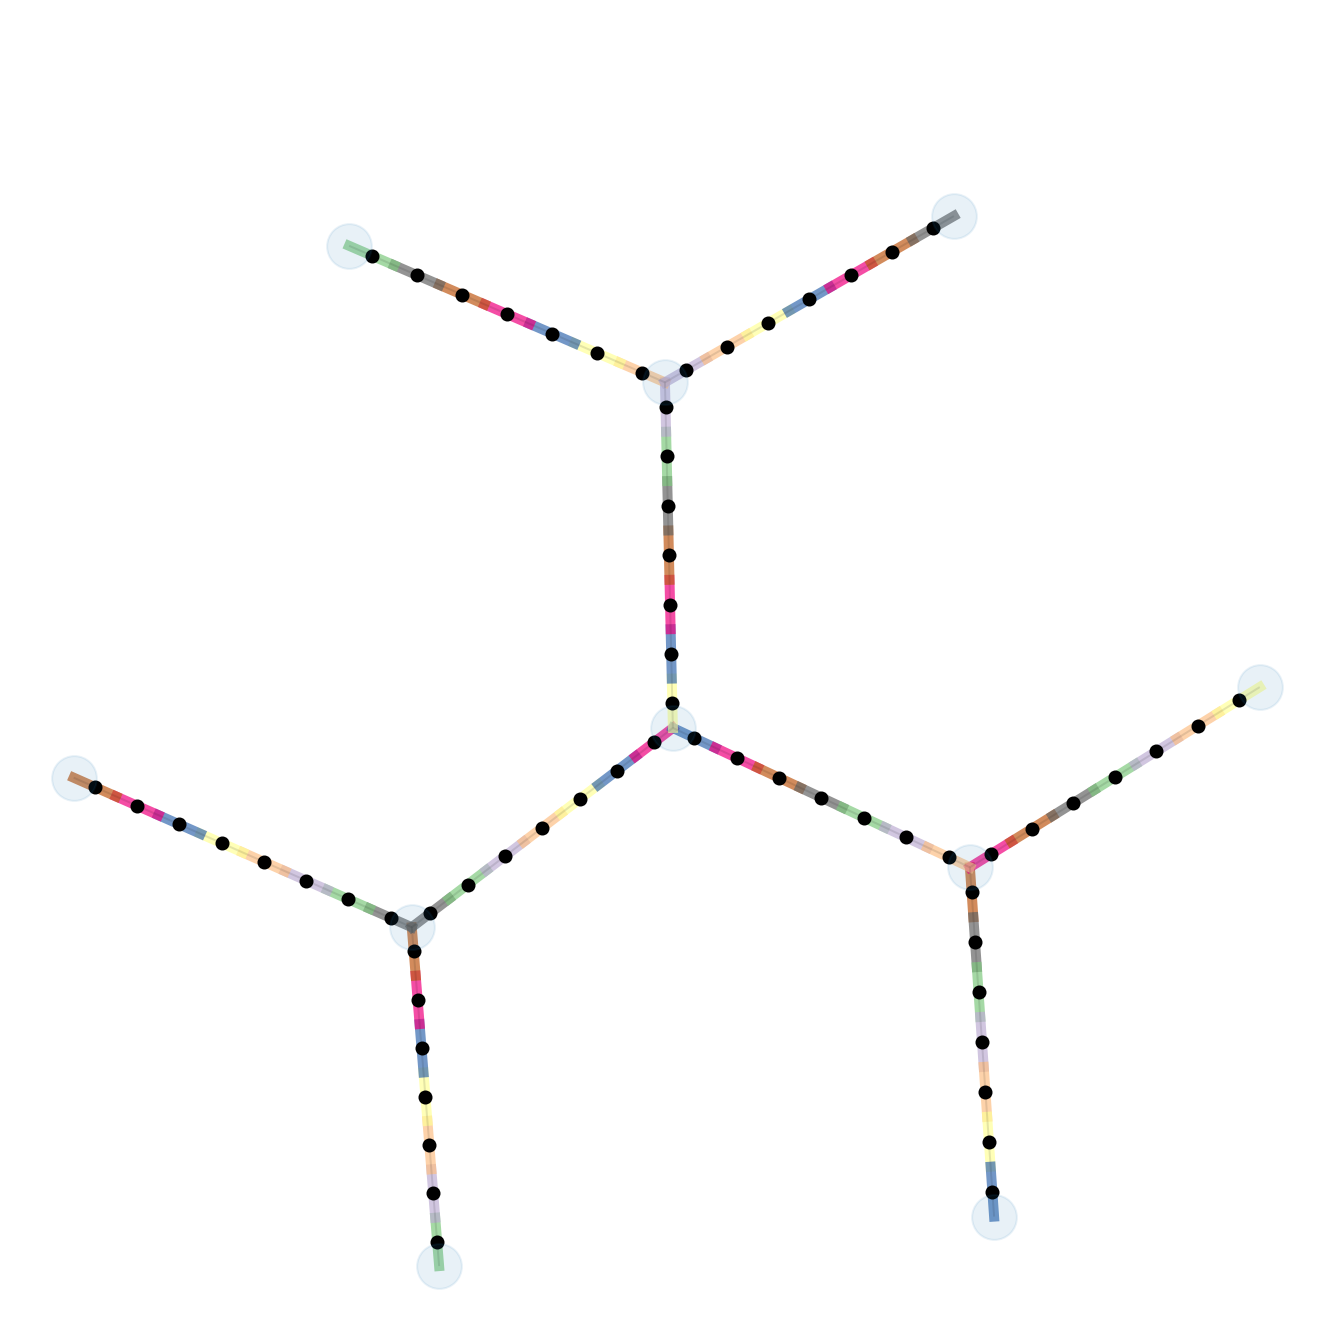

In [271]:
plt.figure(figsize=(12, 12))

plt.scatter(
    place_bin_center_2D_position[is_track_interior, 0],
    place_bin_center_2D_position[is_track_interior, 1],
    color="black",
)

for edge in place_bin_edges_2D_position[is_track_interior]:
    plt.plot(edge[:, 0], edge[:, 1], linewidth=5, zorder=-1, alpha=0.7)

plt.axis("off")
plt.axis("square")

node_position = nx.get_node_attributes(track_graph, "pos")
edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
nx.draw_networkx(
    track_graph,
    node_position,
    width=1,
    alpha=0.1,
    with_labels=False,
    node_size=500,
    zorder=-10,
)

In [284]:
def plot_state_transition_row(bin_ind):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
    axes[0].plot(state_transition[bin_ind] * mask, linewidth=3)
    axes[0].set_xticks(np.arange(place_bin_centers.size) + 0.5)
    axes[0].set_xticklabels(bin_edge)

    m = axes[1].scatter(
        place_bin_center_2D_position[is_track_interior, 0],
        place_bin_center_2D_position[is_track_interior, 1],
        c=state_transition[bin_ind][is_track_interior],
        s=100,
        cmap="magma",
        vmin=0.00,
    )
    axes[1].axis("off")
    plt.colorbar(m, ax=axes[1], orientation="horizontal")

    node_position = nx.get_node_attributes(track_graph, "pos")
    edge_labels = {edge: ind for ind, edge in enumerate(track_graph.edges)}
    nx.draw_networkx(
        track_graph,
        node_position,
        ax=axes[2],
        edge_color=edge_order,
        width=4,
        alpha=1,
        edge_cmap=plt.get_cmap("tab20"),
        with_labels=False,
        node_size=500,
    )
    nx.draw_networkx_edge_labels(
        track_graph, node_position, ax=axes[2], edge_labels=edge_labels
    )
    x, y = track_graph1.nodes[place_bin_center_ind_to_node[bin_ind]]["pos"]
    axes[2].scatter(x, y, s=500, zorder=200, color="red", marker="*")
    axes[2].axis("off")

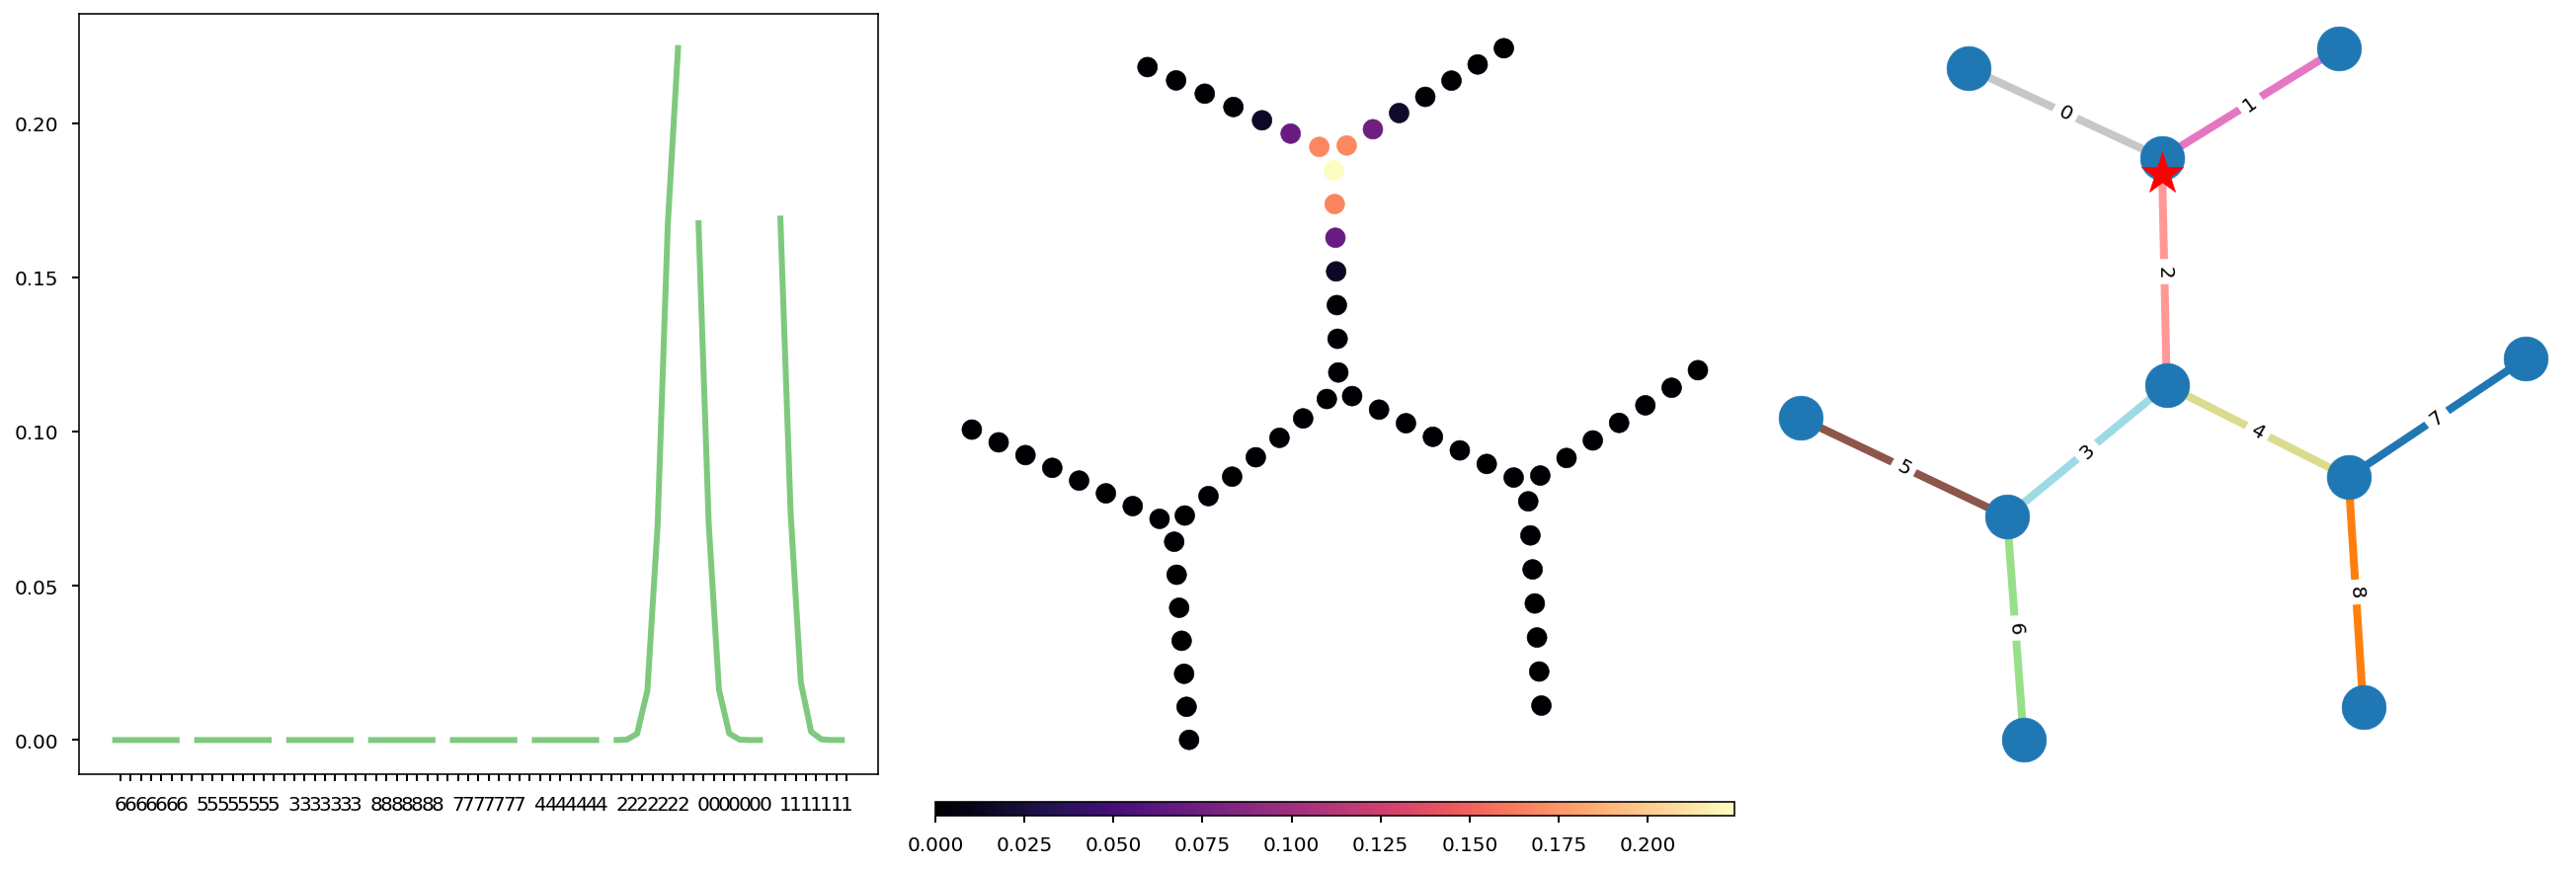

In [290]:
plot_state_transition_row(55)

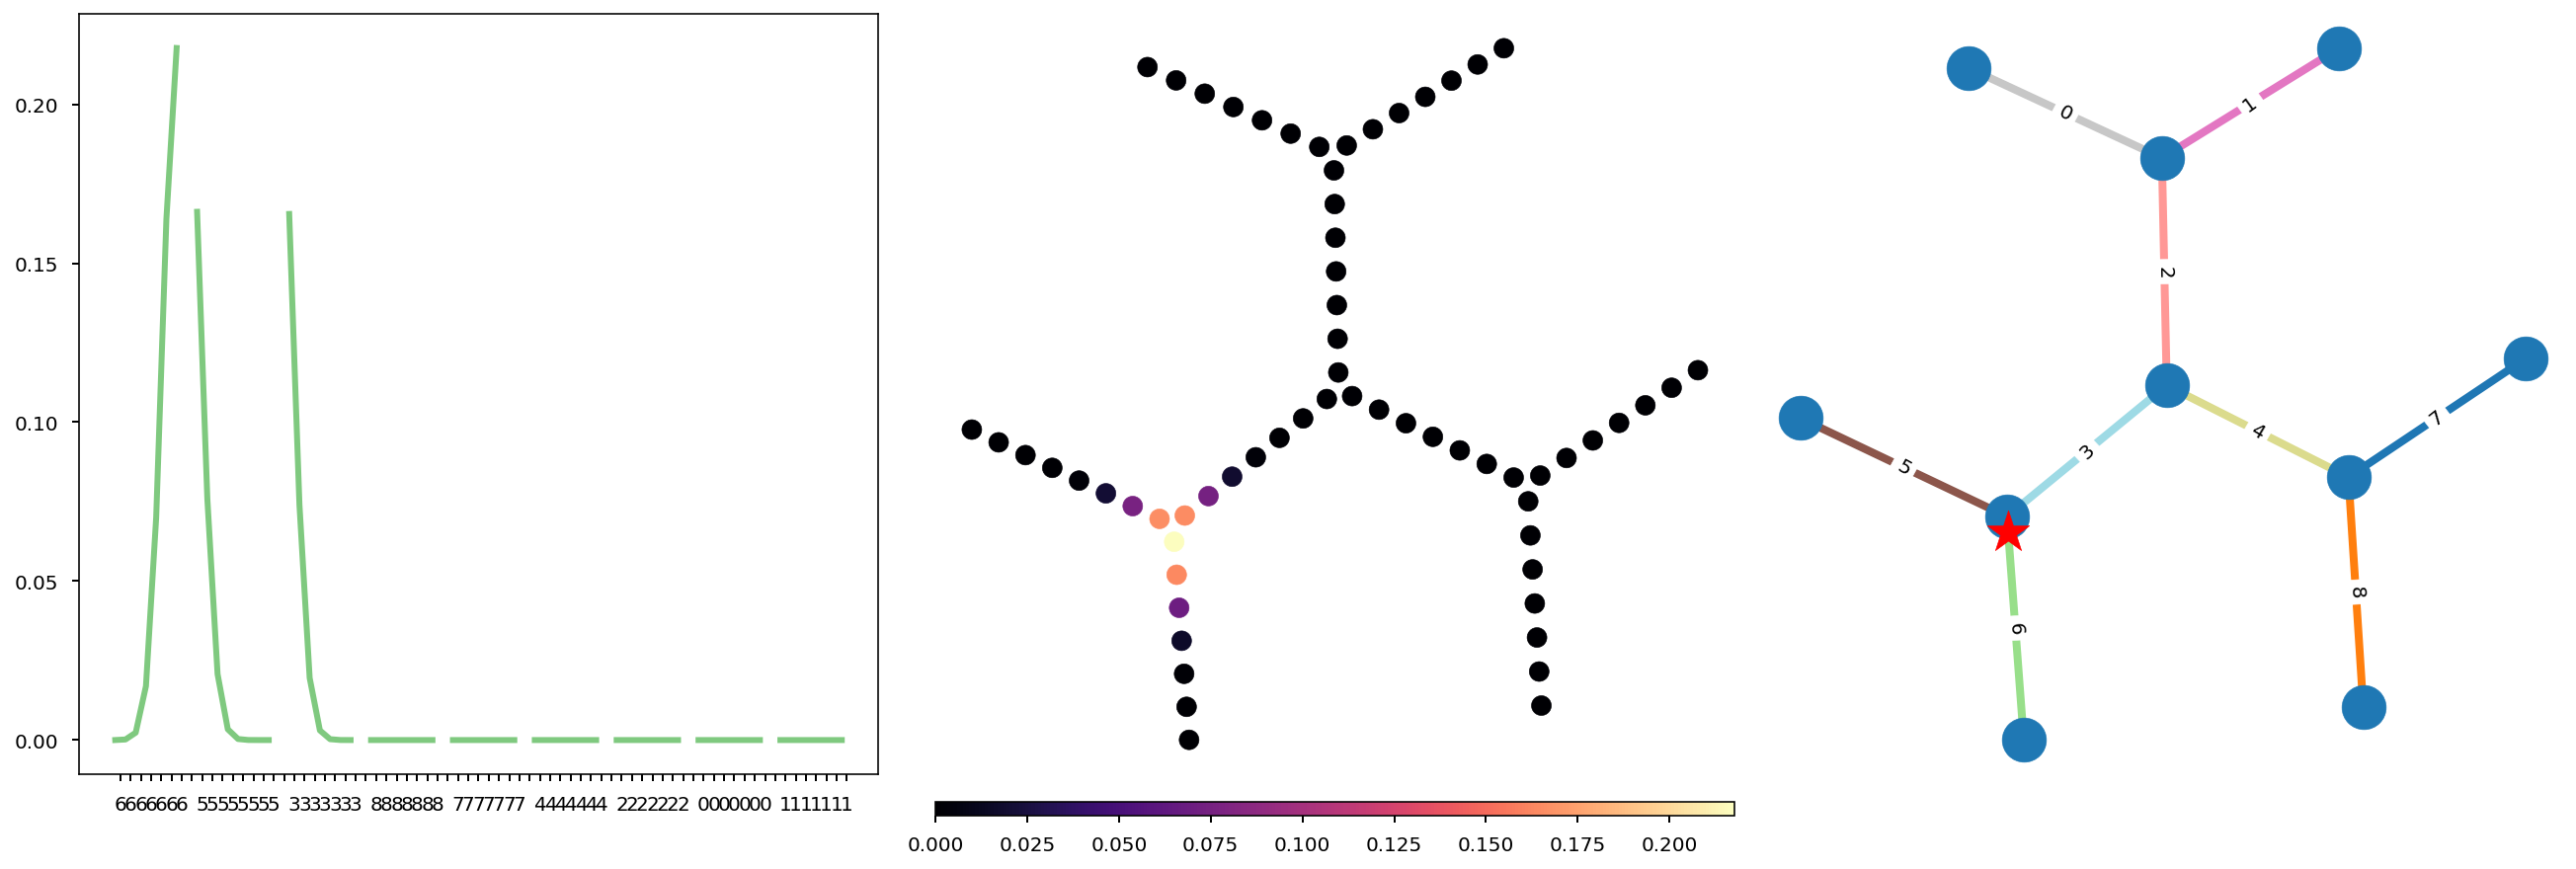

In [292]:
plot_state_transition_row(6)

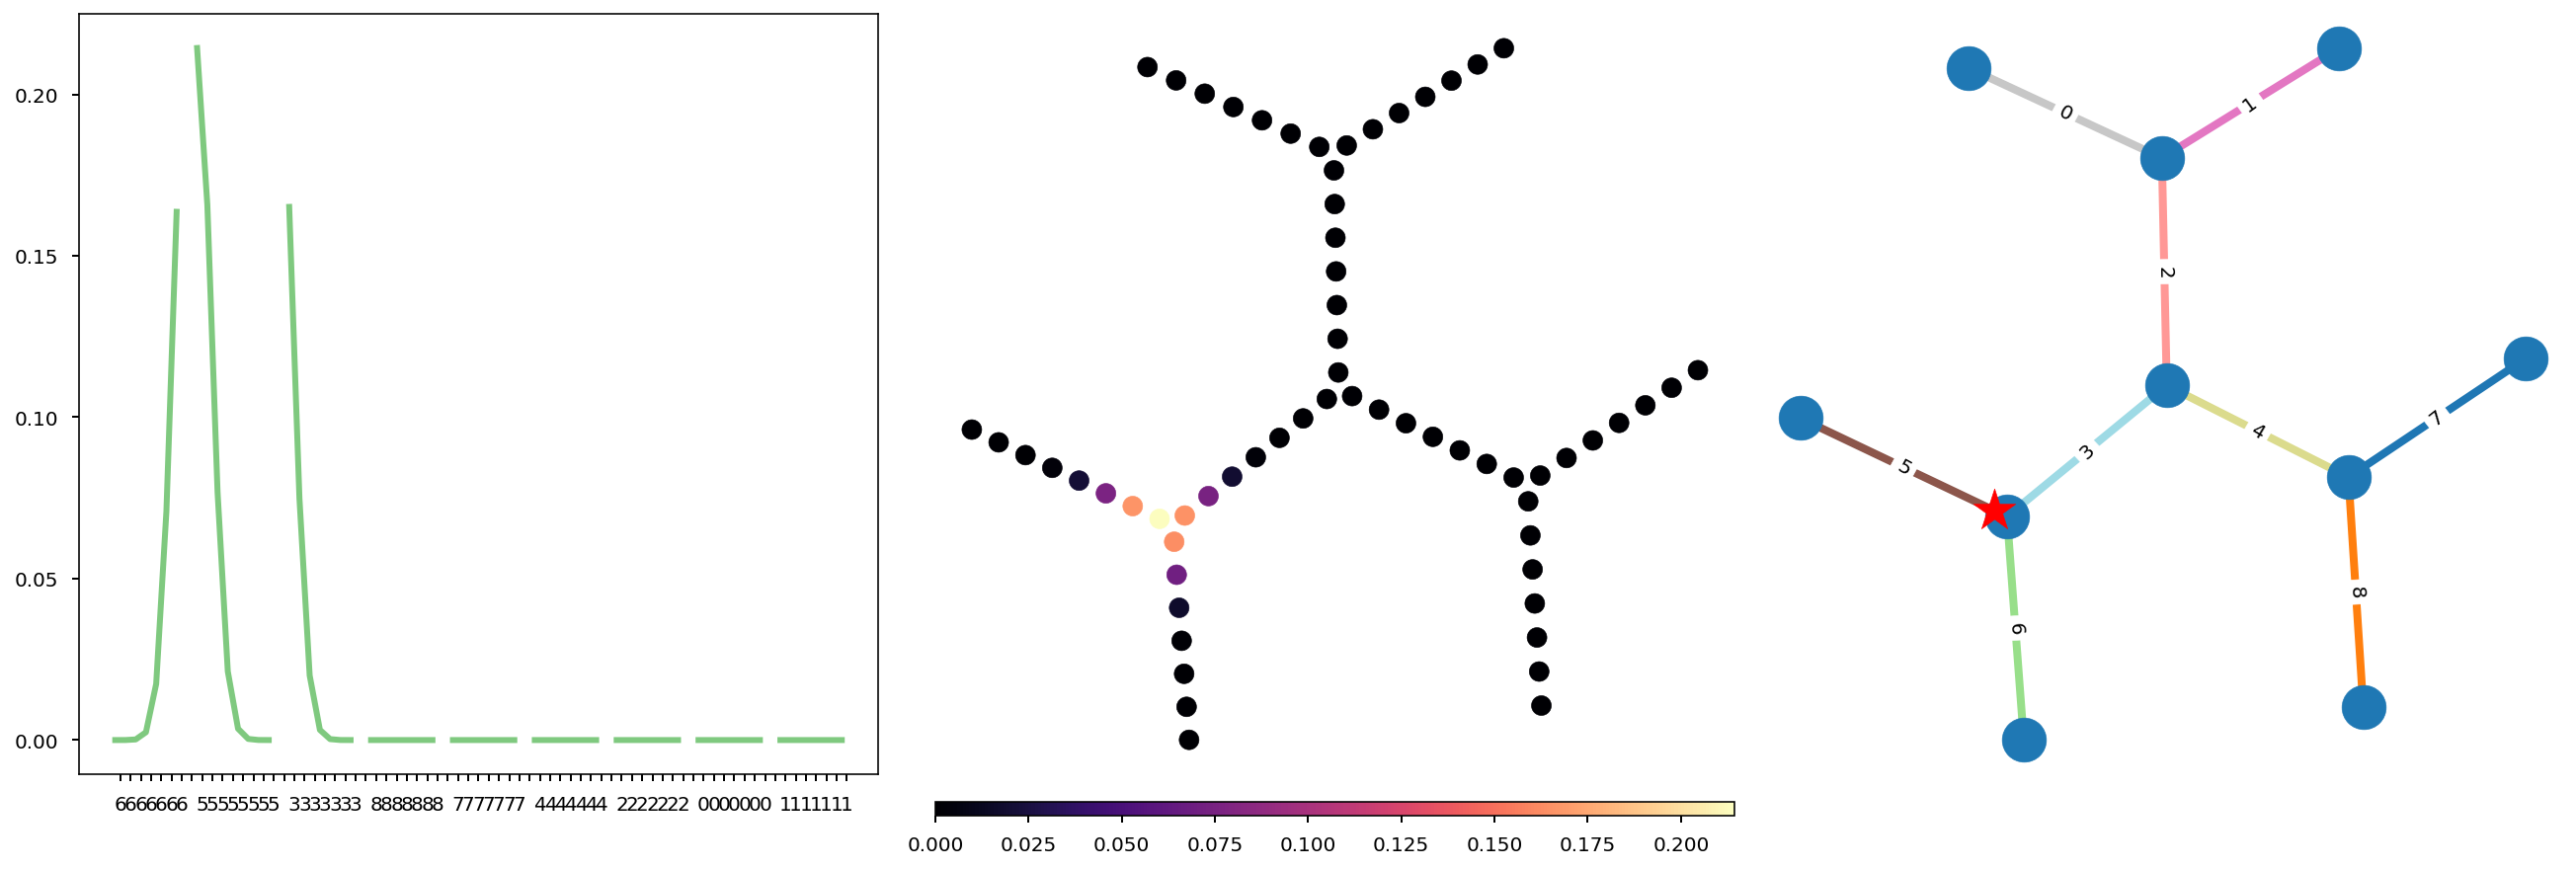

In [293]:
plot_state_transition_row(8)

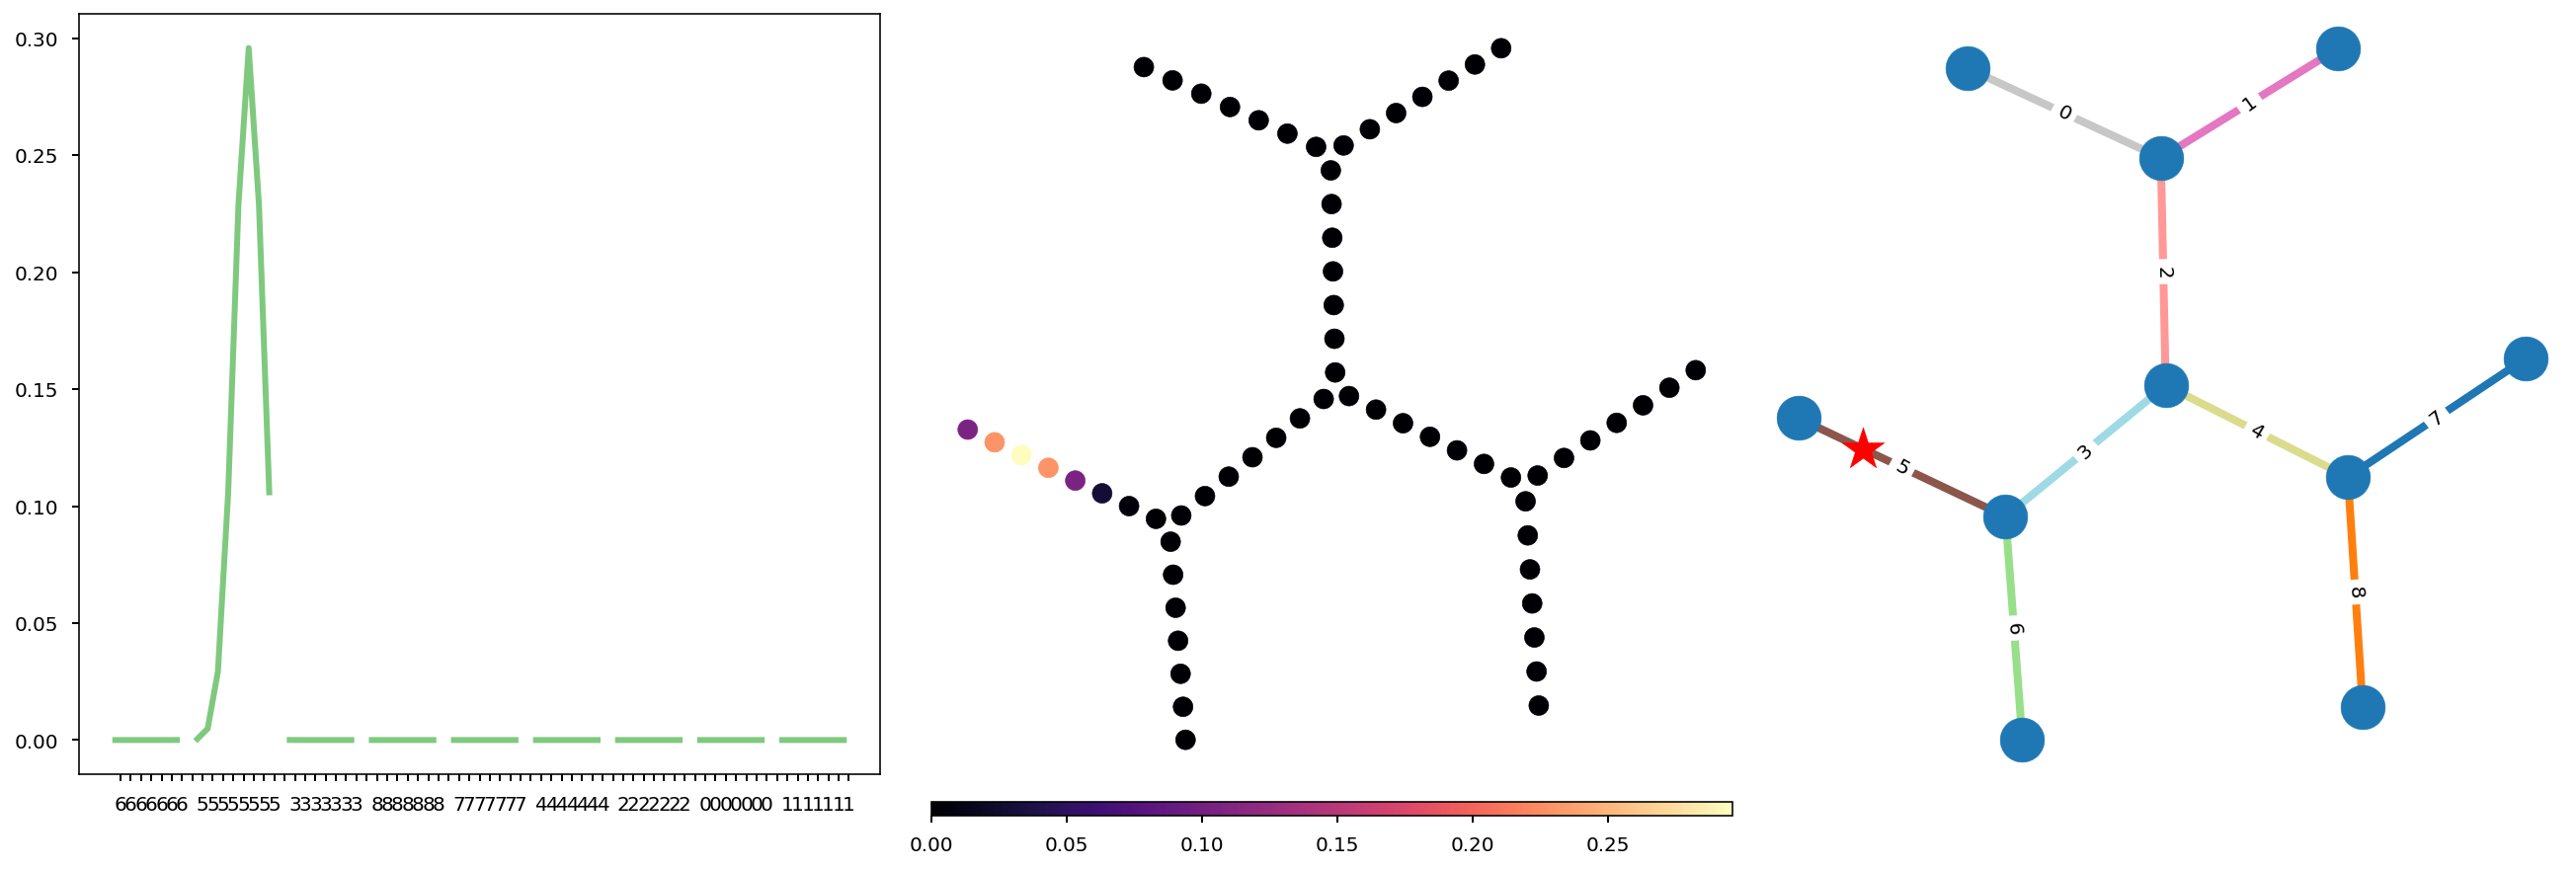

In [294]:
plot_state_transition_row(13)

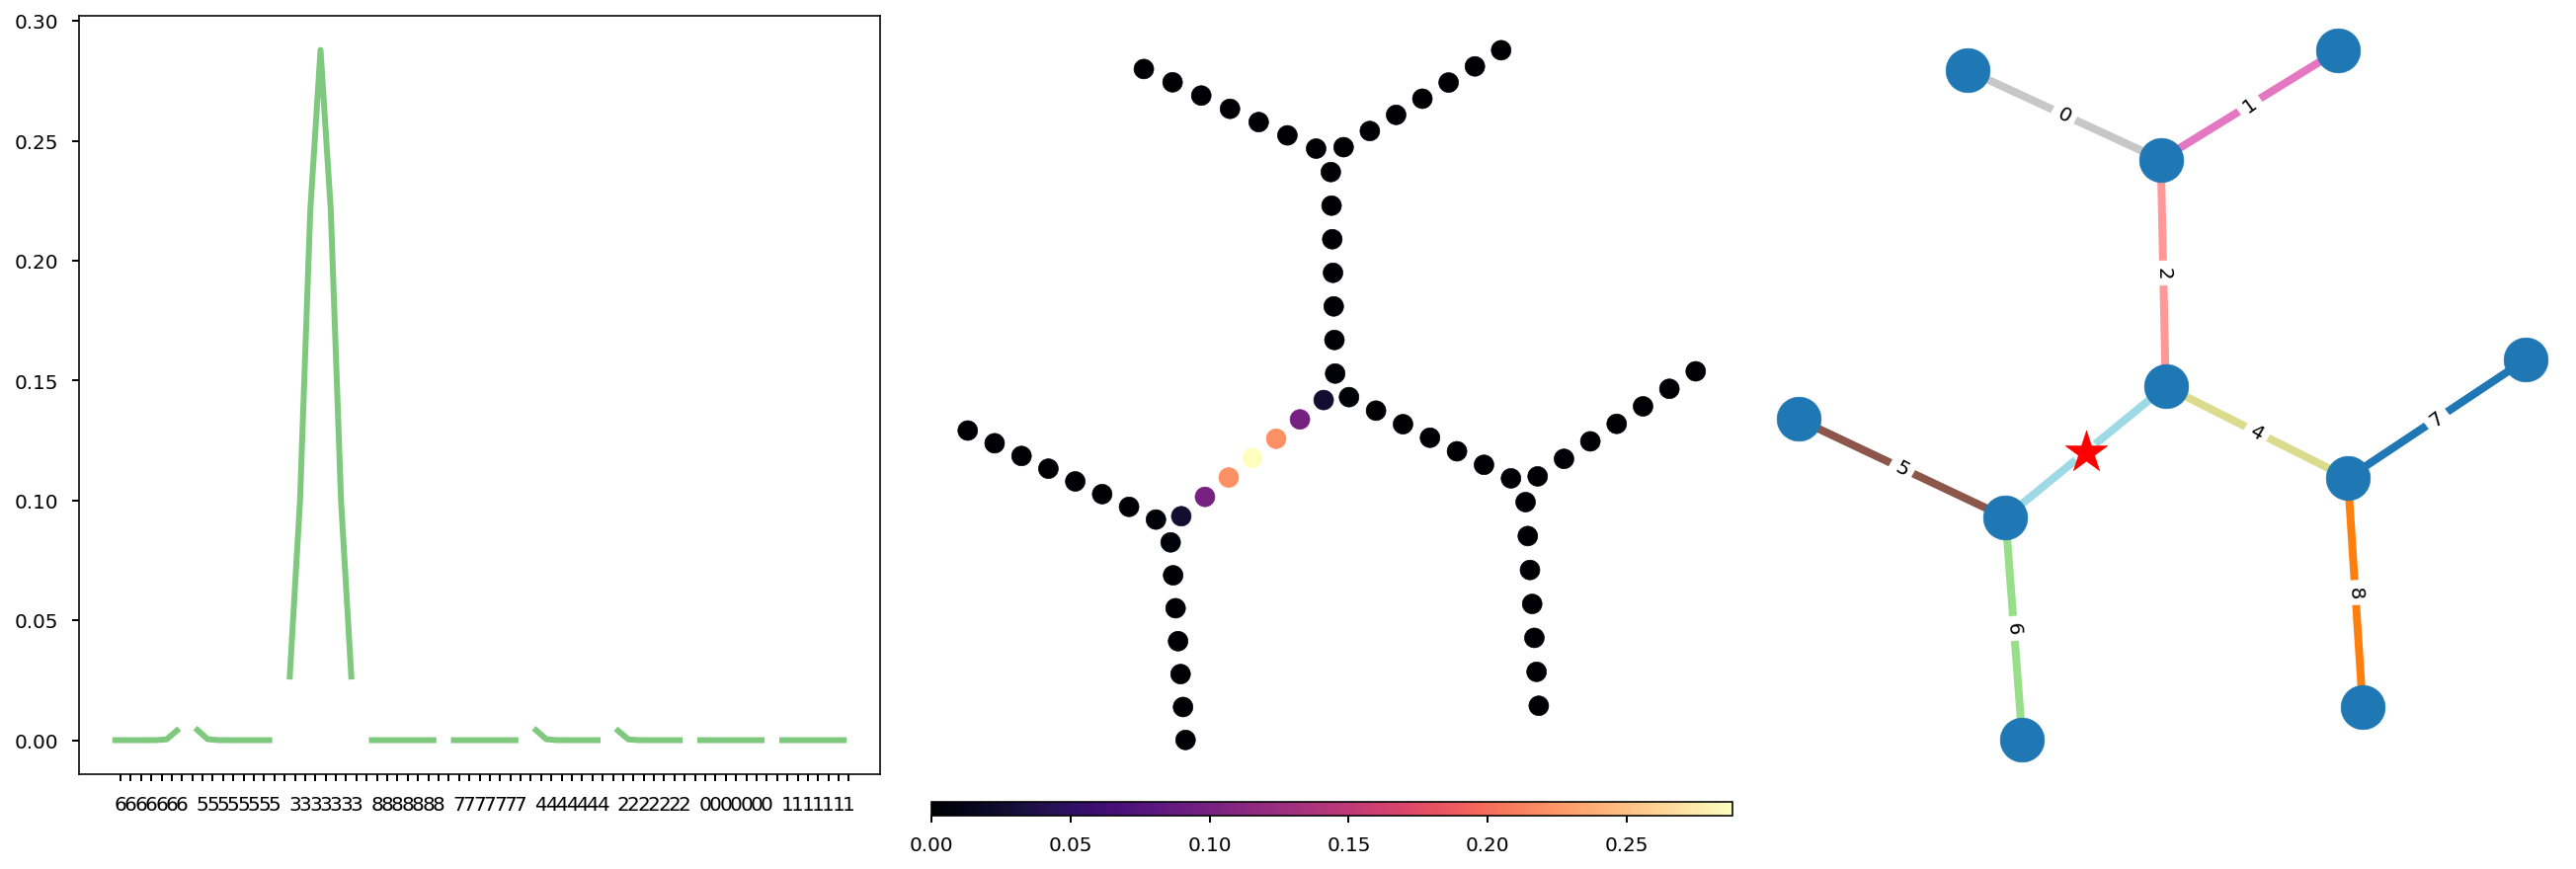

In [297]:
plot_state_transition_row(20)

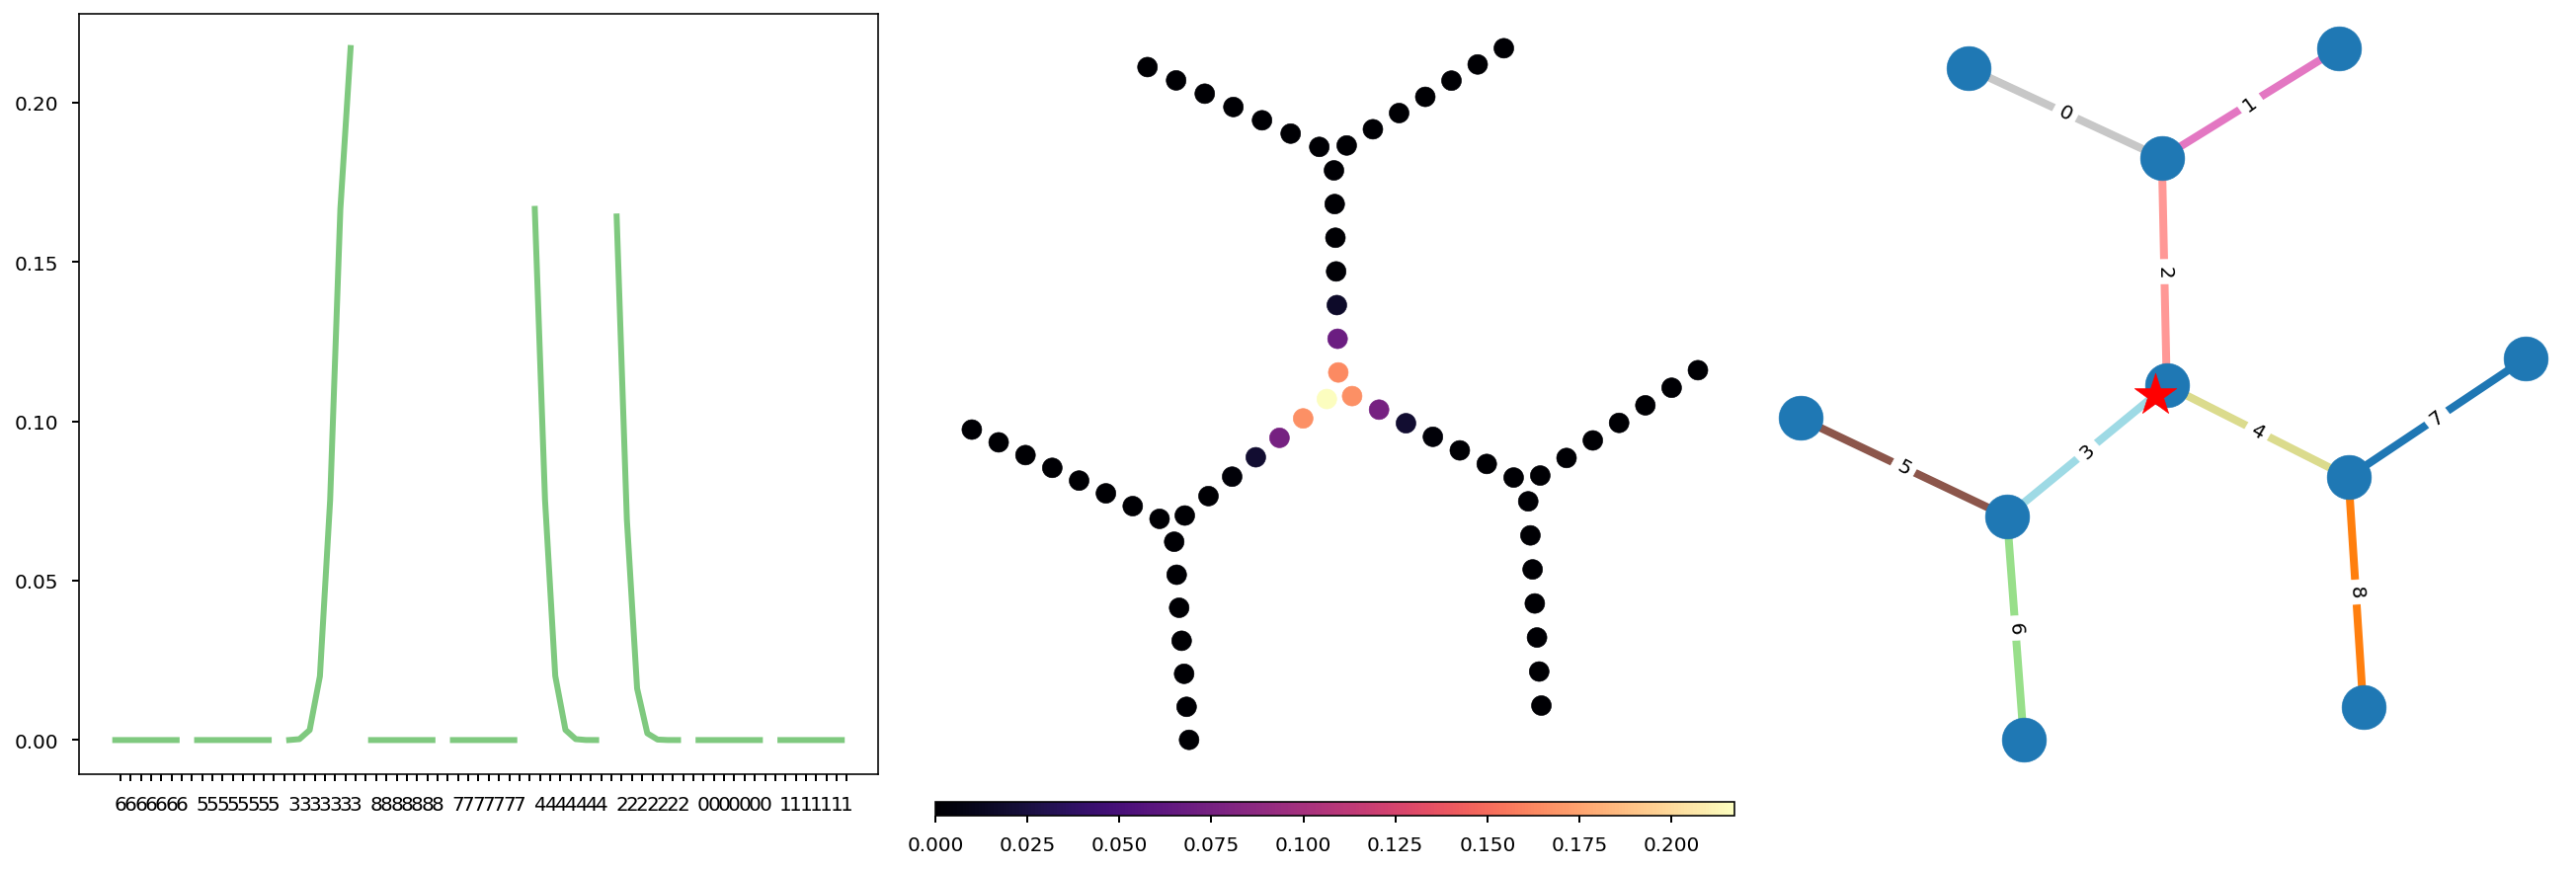

In [299]:
plot_state_transition_row(23)

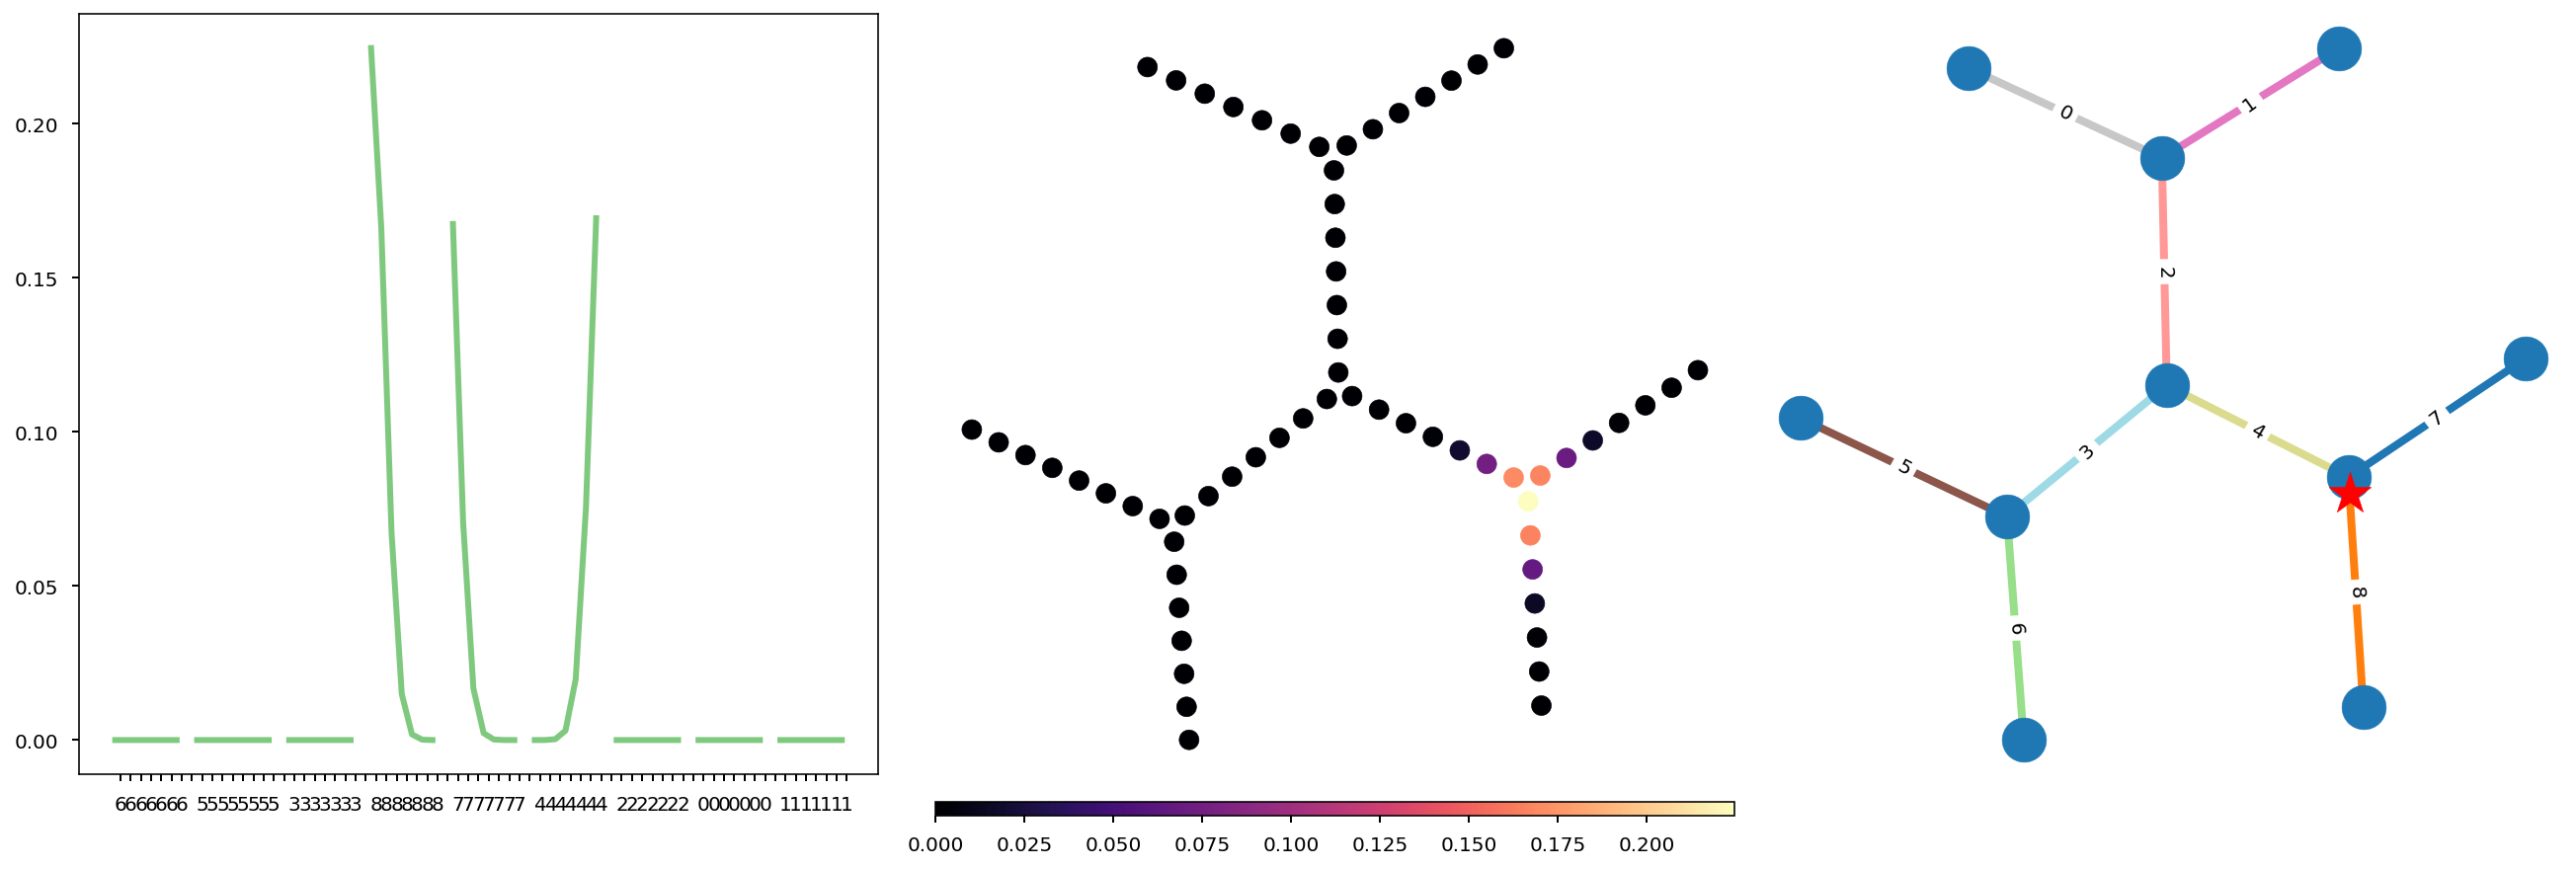

In [300]:
plot_state_transition_row(25)

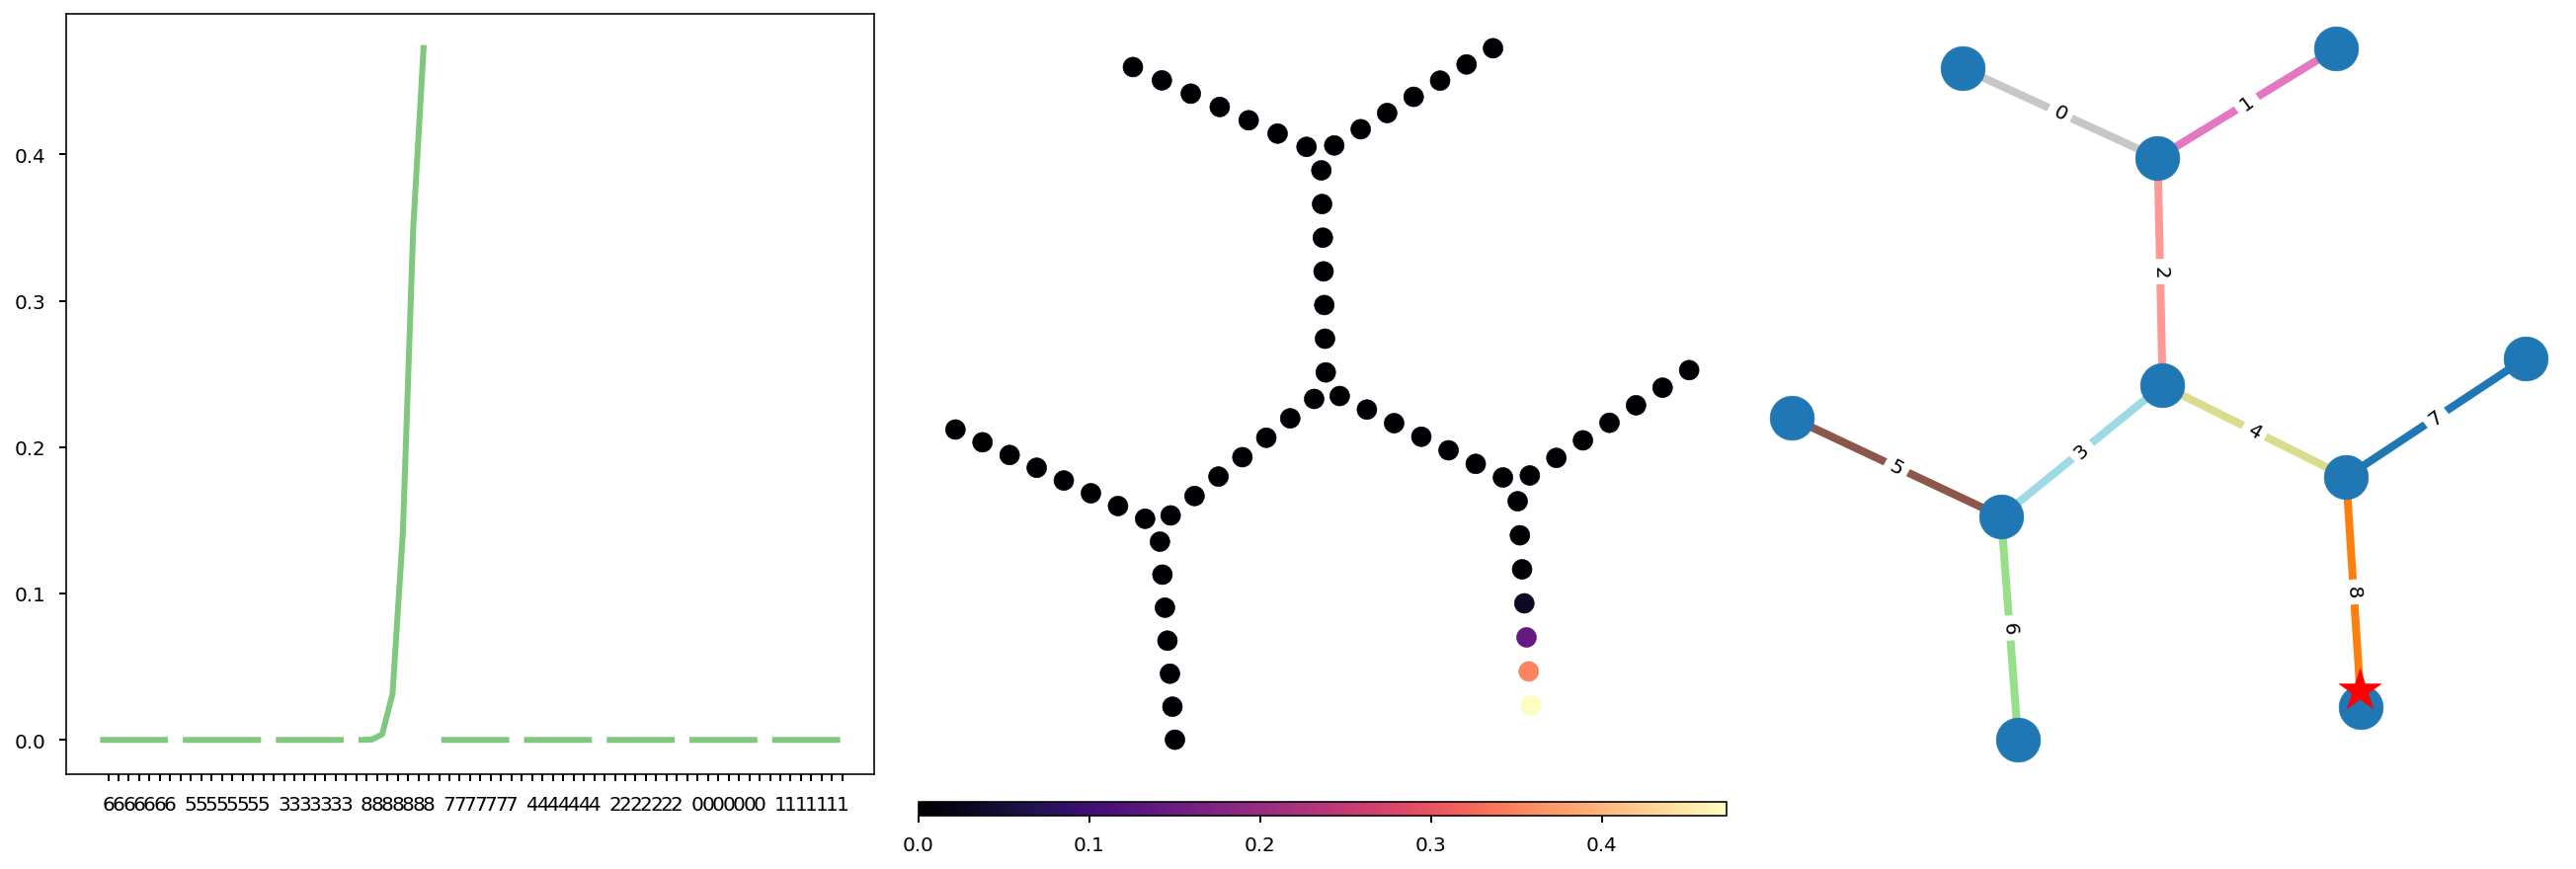

In [304]:
plot_state_transition_row(31)

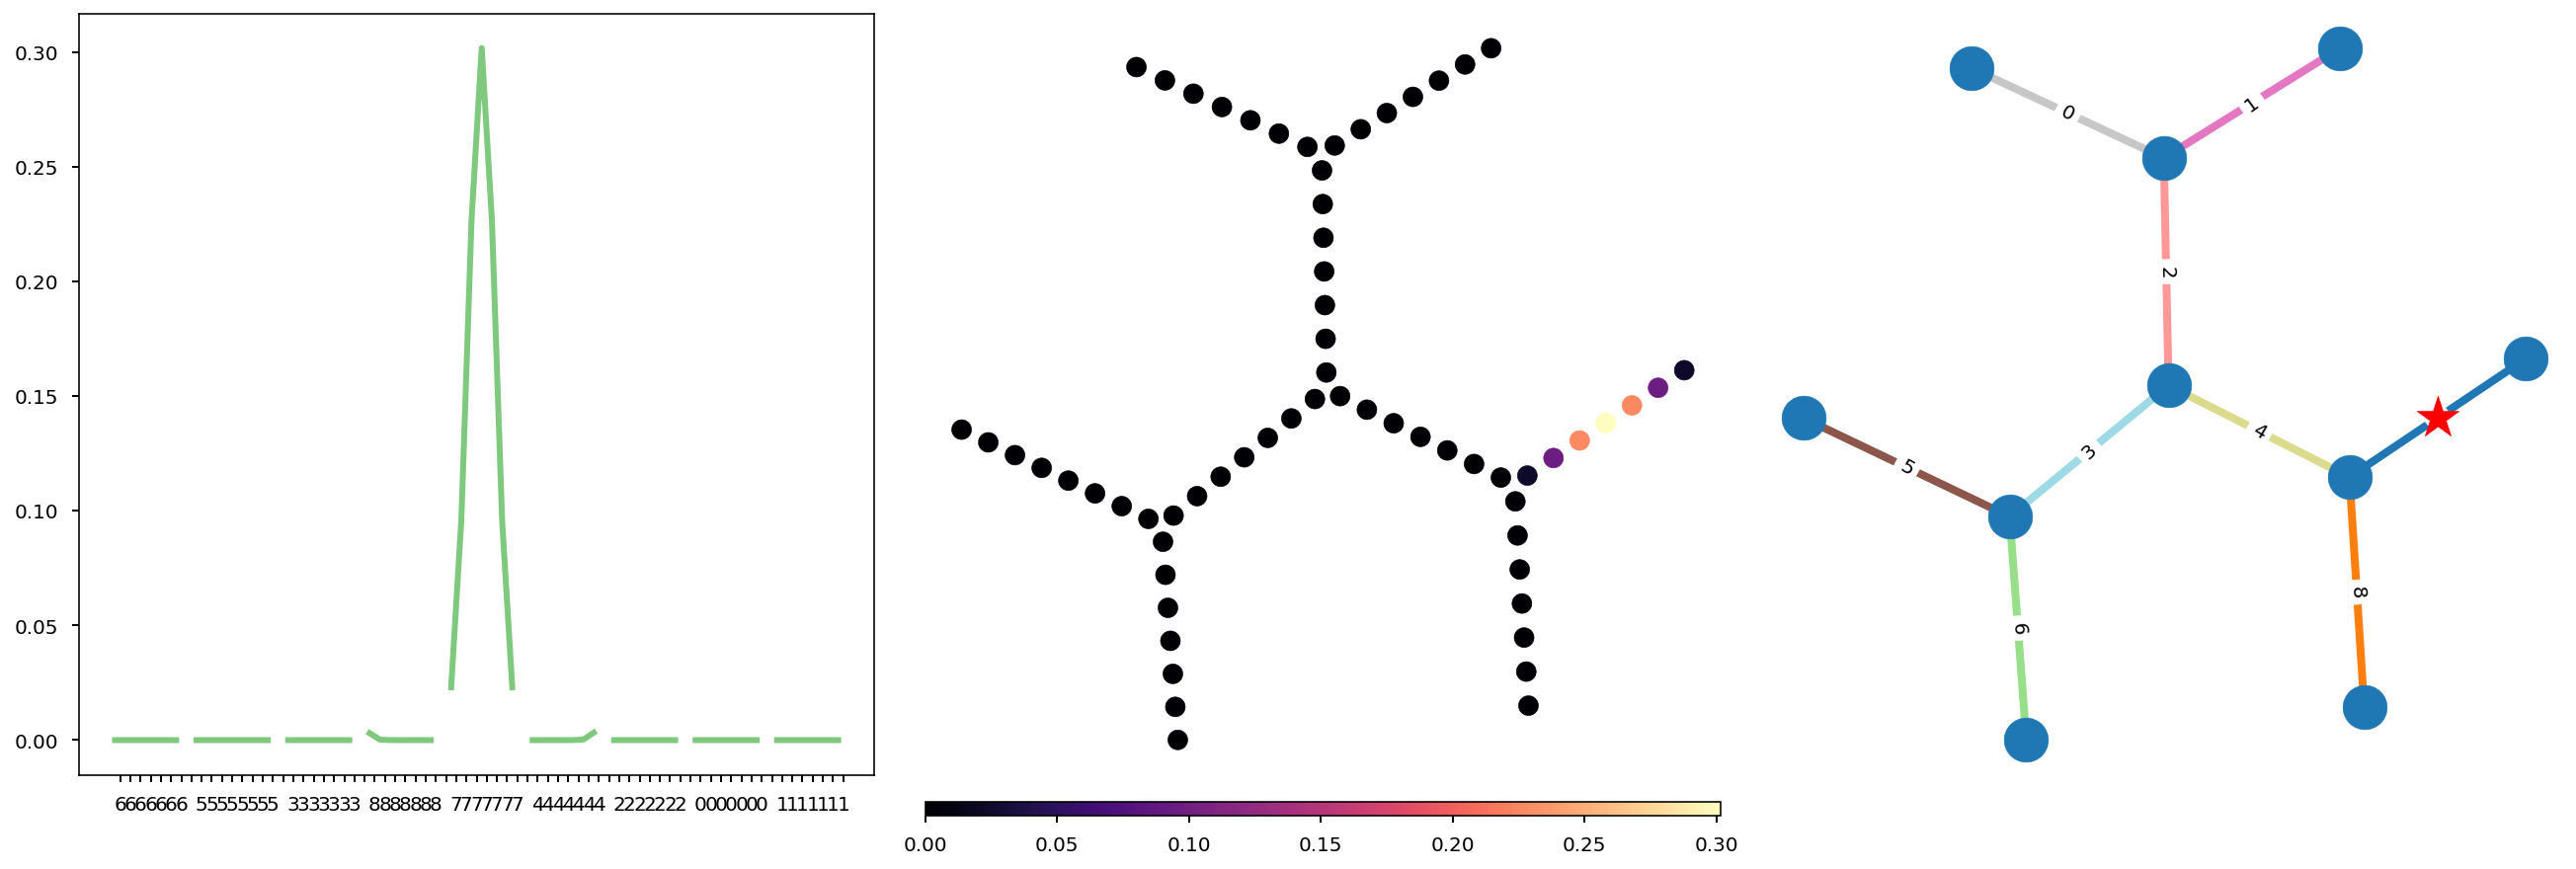

In [306]:
plot_state_transition_row(36)

In [310]:
import holoviews as hv
import xarray as xr

hv.extension("matplotlib")

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [311]:
images = np.stack(
    [
        np.linalg.matrix_power(state_transition.T, speedup)[36] * mask
        for speedup in range(1, 1000, 2)
    ]
).squeeze()
images = xr.DataArray(
    images,
    dims=["time", "position"],
    name="Probability",
    coords=[range(1, 1000, 2), place_bin_centers.squeeze()],
)
ds = hv.Dataset(images)
blah = ds.to(hv.Curve, ["position"]).options(fig_inches=(10, 5))

In [312]:
%%output holomap='mp4'
blah

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x360', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpu_uvwa7i.mp4']


:HoloMap   [time]
   :Curve   [position]   (Probability)

In [313]:
images = np.stack(
    [
        np.linalg.matrix_power(state_transition.T, speedup)[23] * mask
        for speedup in range(1, 1000, 2)
    ]
).squeeze()
images = xr.DataArray(
    images,
    dims=["time", "position"],
    name="Probability",
    coords=[range(1, 1000, 2), place_bin_centers.squeeze()],
)
ds = hv.Dataset(images)
blah = ds.to(hv.Curve, ["position"]).options(fig_inches=(10, 5))

In [314]:
%%output holomap='mp4'
blah

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x360', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp045bsrfp.mp4']


:HoloMap   [time]
   :Curve   [position]   (Probability)

In [315]:
images = np.stack(
    [
        np.linalg.matrix_power(state_transition.T, speedup)[31] * mask
        for speedup in range(1, 1000, 2)
    ]
).squeeze()
images = xr.DataArray(
    images,
    dims=["time", "position"],
    name="Probability",
    coords=[range(1, 1000, 2), place_bin_centers.squeeze()],
)
ds = hv.Dataset(images)
blah = ds.to(hv.Curve, ["position"]).options(fig_inches=(10, 5))

In [316]:
%%output holomap='mp4'
blah

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '720x360', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp3exgyuep.mp4']


:HoloMap   [time]
   :Curve   [position]   (Probability)